In [ ]:
###################################################################################################################################
###################################################################################################################################
###  
###  Case Study Name        :  Identifying Key Entities in Recipe Data
###
###  Case Study Goal        :  To automatically convert unstructured recipe text into structured, actionable data (quantity, unit, ingredient) to power new digital features and business analytics)              
###
###  Author                 :  Saurabh Tayde
###
###  Email                  :  saurabhtayde2810@gmail.com
###
###  Date                   :  9th July 2025
###              
###################################################################################################################################
###################################################################################################################################

# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
#!pip install sklearn_crfsuite==0.5.0

In [ ]:
# Install spaCy model
#!python -m spacy download en_core_web_sm

In [ ]:
#!pip install spacy

#### **1.2** Import necessary libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [6]:
# define a function to load json file to a dataframe

def load_json_dataframe(file_path):
    """
    Load JSON data from file and convert to pandas DataFrame
    
    Args:
        file_path (str): Path to the JSON file
    
    Returns:
        pd.DataFrame: DataFrame containing the recipe data
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe

df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df

df.head()


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [9]:
# print the dimensions of dataframe - df

print(f"DataFrame dimensions: {df.shape}")


DataFrame dimensions: (285, 2)


In [10]:
# print the information of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [11]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [12]:
# display first five rows of the dataframe - df

df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [13]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


In [14]:
# check for the equality of input_length and pos_length in the dataframe

length_mismatch = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with length mismatch: {len(length_mismatch)}")
if len(length_mismatch) > 0:
    print("Rows with unequal input and pos length:")
    print(length_mismatch[['input_length', 'pos_length']].head(10))
else:
    print("All rows have equal input and pos token lengths")


Number of rows with length mismatch: 5
Rows with unequal input and pos length:
     input_length  pos_length
17             15          14
27             37          36
79             38          37
164            54          53
207            18          17


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [15]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(dataframe):
    """
    Extract all unique POS labels from the pos_tokens column
    
    Args:
        dataframe (pd.DataFrame): DataFrame containing pos_tokens column
    
    Returns:
        set: Set of unique labels
    """
    all_labels = []
    for pos_list in dataframe['pos_tokens']:
        all_labels.extend(pos_list)
    unique_labels_set = set(all_labels)
    print(f"Number of unique labels: {len(unique_labels_set)}")
    print(f"Unique labels: {sorted(unique_labels_set)}")
    return unique_labels_set

# Execute the function
unique_labels_result = unique_labels(df)


Number of unique labels: 3
Unique labels: ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe


##### Based on the validation results, the following indexes require cleaning and formatting due to length mismatches between input tokens and POS tokens:

* Index 17: input_length=15, pos_length=14
* Index 27: input_length=37, pos_length=36
* Index 79: input_length=38, pos_length=37
* Index 164: input_length=54, pos_length=53
* Index 207: input_length=18, pos_length=17

##### These 5 rows have inconsistent token counts which will cause issues in sequence labeling, so they need to be removed from the dataset.

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [16]:
# drop the irrelevant recipe data

df_cleaned = df[df['input_length'] == df['pos_length']].copy()
print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")
print(f"Removed {len(df) - len(df_cleaned)} rows with length mismatches")


Original dataset size: 285
Cleaned dataset size: 280
Removed 5 rows with length mismatches


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [17]:
# update the input and pos length in input_length and pos_length

df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [18]:
# validate the input length and pos length as input_length and pos_length

length_validation = df_cleaned[df_cleaned['input_length'] != df_cleaned['pos_length']]
print(f"Number of rows with length mismatch after cleaning: {len(length_validation)}")
if len(length_validation) == 0:
    print("✓ All rows now have equal input and pos token lengths")
else:
    print("✗ Still have length mismatches:", length_validation.index.tolist())


Number of rows with length mismatch after cleaning: 0
✓ All rows now have equal input and pos token lengths


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [19]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42, shuffle=True)
print(f"Training set size: {len(train_df)} recipes")
print(f"Validation set size: {len(val_df)} recipes")
print(f"Split ratio - Train: {len(train_df)/len(df_cleaned)*100:.1f}%, Validation: {len(val_df)/len(df_cleaned)*100:.1f}%")

Training set size: 196 recipes
Validation set size: 84 recipes
Split ratio - Train: 70.0%, Validation: 30.0%


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [20]:
# print the first five rows of train_df

print("First 5 rows of Training DataFrame:")

train_df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']]


First 5 rows of Training DataFrame:


input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
179                                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                                [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57                   [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]            41          41
112                                                                                                                                       [500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]                                                                                                                                                                                                                      [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            25          25
218                                                                                                                                                                              [500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]                                                                                                                                                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]            21          21
40                                                                                                                                                                                         

In [21]:
# print the first five rows of the val_df

print("\nFirst 5 rows of Validation DataFrame:")

val_df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']].head()



First 5 rows of Validation DataFrame:


input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                                                                [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  [1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]  [quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            56          56
245                                                                                                                                                                [1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]                                                                                                                                                                                                                                          [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            35          35
264                                                                                                        

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [22]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()


Dataset Split Summary:
X_train length: 196 recipes
X_val length: 84 recipes
y_train length: 196 recipes
y_val length: 84 recipes


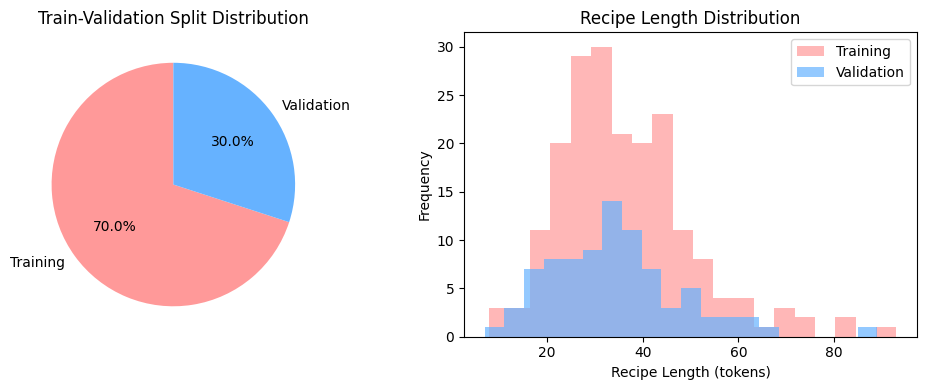

In [23]:
# validate the shape of training and validation samples

print("Dataset Split Summary:")
print(f"X_train length: {len(X_train)} recipes")
print(f"X_val length: {len(X_val)} recipes")
print(f"y_train length: {len(y_train)} recipes")
print(f"y_val length: {len(y_val)} recipes")

# Visualization of split distribution
plt.figure(figsize=(10, 4))

# Subplot 1: Split distribution
plt.subplot(1, 2, 1)
sizes = [len(X_train), len(X_val)]
labels = ['Training', 'Validation']
colors = ['#FF9999', '#66B2FF']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Train-Validation Split Distribution')

# Subplot 2: Recipe length distribution
plt.subplot(1, 2, 2)
train_lengths = [len(recipe) for recipe in X_train]
val_lengths = [len(recipe) for recipe in X_val]
plt.hist(train_lengths, bins=20, alpha=0.7, label='Training', color='#FF9999')
plt.hist(val_lengths, bins=20, alpha=0.7, label='Validation', color='#66B2FF')
plt.xlabel('Recipe Length (tokens)')
plt.ylabel('Frequency')
plt.title('Recipe Length Distribution')
plt.legend()

plt.tight_layout()
plt.show()


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

Number of unique labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']

Label distribution in training set:
  quantity: 980 tokens (13.78%)
  unit: 811 tokens (11.40%)
  ingredient: 5,323 tokens (74.82%)


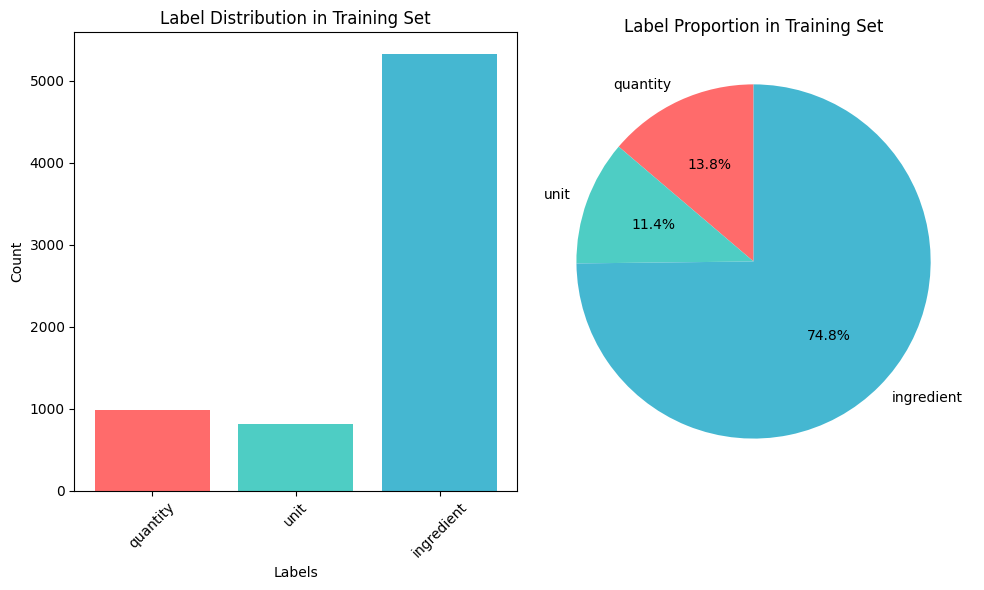

In [24]:
# Display the number of unique labels present in y_train

# Flatten all labels from training set
all_train_labels = []
for recipe_labels in y_train:
    all_train_labels.extend(recipe_labels)

unique_train_labels = set(all_train_labels)
label_counts = Counter(all_train_labels)

print(f"Number of unique labels in y_train: {len(unique_train_labels)}")
print(f"Unique labels: {sorted(unique_train_labels)}")
print(f"\nLabel distribution in training set:")
for label, count in label_counts.items():
    percentage = (count / len(all_train_labels)) * 100
    print(f"  {label}: {count:,} tokens ({percentage:.2f}%)")

# Visualization of label distribution
plt.figure(figsize=(10, 6))
labels = list(label_counts.keys())
counts = list(label_counts.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.subplot(1, 2, 1)
plt.bar(labels, counts, color=colors)
plt.title('Label Distribution in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Label Proportion in Training Set')

plt.tight_layout()
plt.show()


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [25]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    """
    Flatten a nested list structure into a single list
    
    Args:
        nested_list (list): List of lists to be flattened
    
    Returns:
        list: Flattened list containing all elements
    """
    flattened = []
    for sublist in nested_list:
        flattened.extend(sublist)
    return flattened


In [26]:
# initialise the dataset_name
dataset_name = 'Training'

print(f"Dataset name initialized: {dataset_name}")

Dataset name initialized: Training


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [27]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    """
    Extract and validate tokens using flattening technique
    
    Args:
        df (pd.DataFrame): DataFrame containing input_tokens and pos_tokens
        dataset_name (str): Name of the dataset (Training/Validation)
    
    Returns:
        tuple: (flattened_input_tokens, flattened_pos_tokens)
    """
    print(f"\n=== {dataset_name} Dataset Token Extraction ===")
    
    # Apply flatten_list function on input_tokens and pos_tokens
    flattened_input_tokens = flatten_list(df['input_tokens'].tolist())
    flattened_pos_tokens = flatten_list(df['pos_tokens'].tolist())
    
    # Validate their lengths
    print(f"Total input tokens: {len(flattened_input_tokens):,}")
    print(f"Total pos tokens: {len(flattened_pos_tokens):,}")
    print(f"Length match: {len(flattened_input_tokens) == len(flattened_pos_tokens)}")
    
    # Display first 10 records
    print(f"\nFirst 10 input tokens: {flattened_input_tokens[:10]}")
    print(f"First 10 pos tokens: {flattened_pos_tokens[:10]}")
    
    # Create visualization
    plt.figure(figsize=(12, 5))
    
    # Token length comparison
    plt.subplot(1, 2, 1)
    categories = ['Input Tokens', 'POS Tokens']
    counts = [len(flattened_input_tokens), len(flattened_pos_tokens)]
    colors = ['#FF6B6B', '#4ECDC4']
    bars = plt.bar(categories, counts, color=colors)
    plt.title(f'{dataset_name} Dataset: Token Count Comparison')
    plt.ylabel('Number of Tokens')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Recipe length distribution
    plt.subplot(1, 2, 2)
    recipe_lengths = [len(recipe) for recipe in df['input_tokens']]
    plt.hist(recipe_lengths, bins=15, color='#45B7D1', alpha=0.7, edgecolor='black')
    plt.title(f'{dataset_name} Dataset: Recipe Length Distribution')
    plt.xlabel('Recipe Length (tokens)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    mean_length = np.mean(recipe_lengths)
    plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_length:.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return flattened_input_tokens, flattened_pos_tokens



=== Training Dataset Token Extraction ===
Total input tokens: 7,114
Total pos tokens: 7,114
Length match: True

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 pos tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


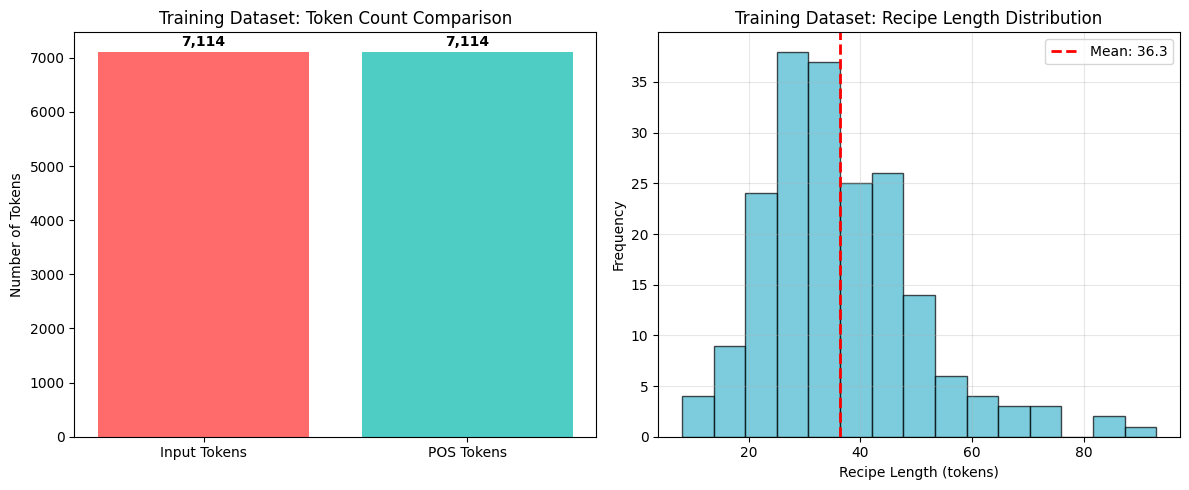

In [28]:
# extract the tokens and its pos tags

input_tokens, pos_tokens = extract_and_validate_tokens(train_df, dataset_name)

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [29]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays


def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units and quantities based on POS tags
    
    Args:
        tokens (list): List of input tokens
        pos_tags (list): List of corresponding POS tags
    
    Returns:
        tuple: (ingredients_list, units_list, quantities_list)
    """
    # Validate input lengths
    if len(tokens) != len(pos_tags):
        print("Error: Tokens and POS tags length mismatch!")
        return [], [], []
    
    # Initialize lists for each category
    ingredients_list = []
    units_list = []
    quantities_list = []
    
    # Categorize tokens based on their POS tags
    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == 'ingredient':
            ingredients_list.append(token)
        elif pos_tag == 'unit':
            units_list.append(token)
        elif pos_tag == 'quantity':
            quantities_list.append(token)
    
    # Print categorization summary
    print("=== Token Categorization Summary ===")
    print(f"Total tokens processed: {len(tokens):,}")
    print(f"Ingredients: {len(ingredients_list):,} tokens")
    print(f"Units: {len(units_list):,} tokens") 
    print(f"Quantities: {len(quantities_list):,} tokens")
    print(f"Total categorized: {len(ingredients_list) + len(units_list) + len(quantities_list):,}")
    
    return ingredients_list, units_list, quantities_list


=== Token Categorization Summary ===
Total tokens processed: 7,114
Ingredients: 5,323 tokens
Units: 811 tokens
Quantities: 980 tokens
Total categorized: 7,114


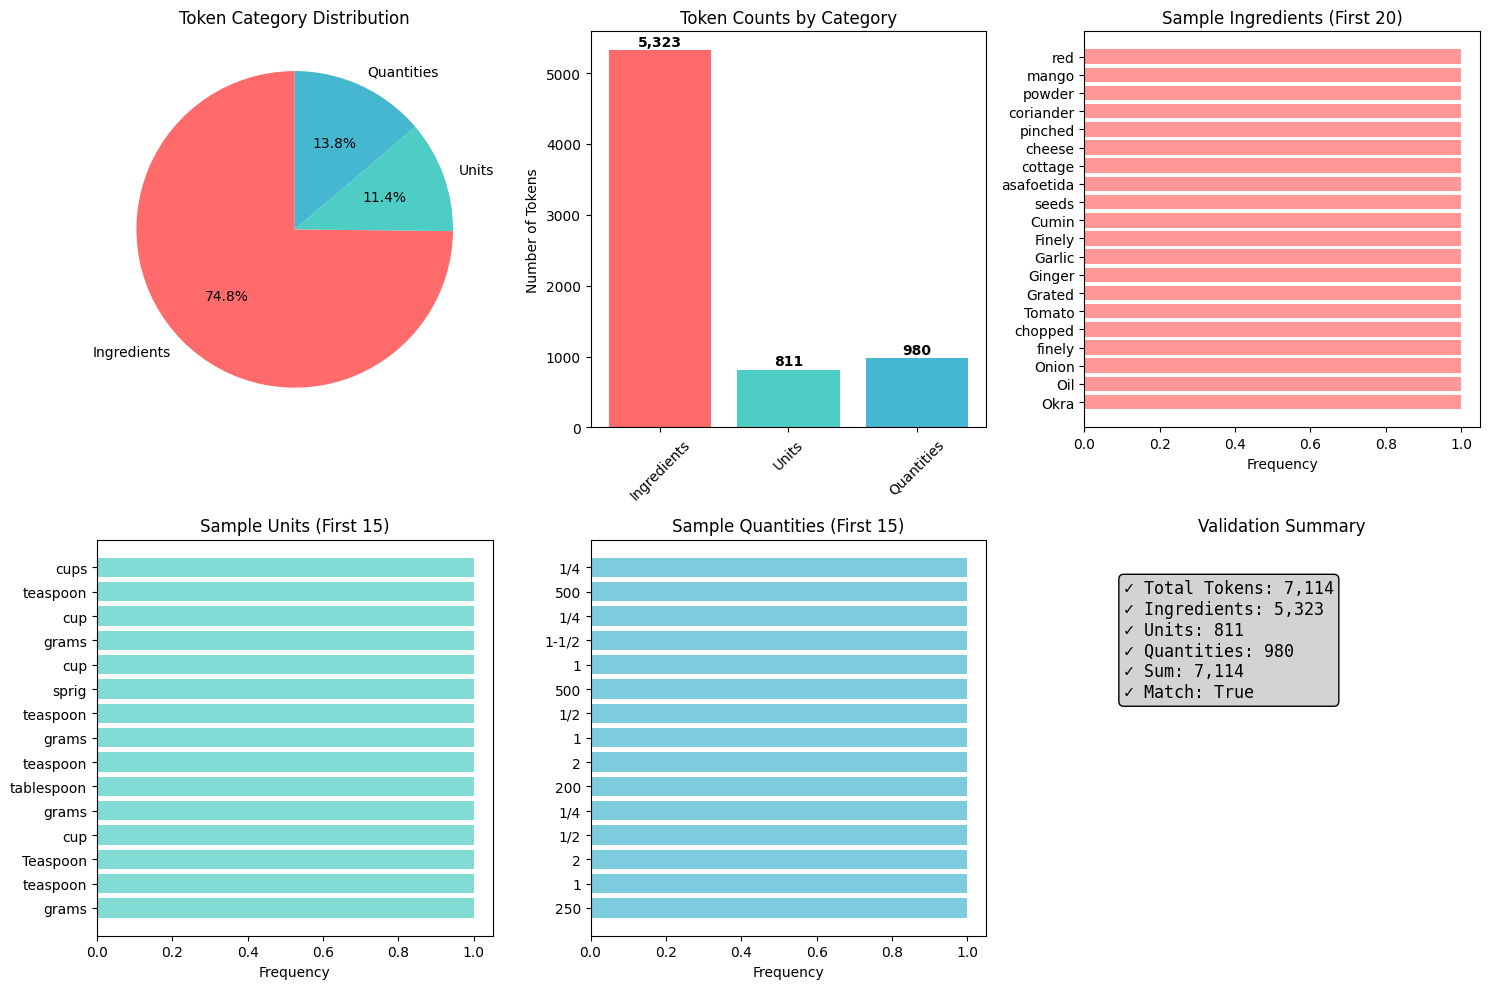


=== Sample Examples ===
Sample ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Sample units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Sample quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


In [30]:
# call the function to categorise the labels into respective list

ingredients, units, quantities = categorize_tokens(input_tokens, pos_tokens)

# Create comprehensive visualization of categorized tokens
plt.figure(figsize=(15, 10))

# Subplot 1: Category distribution
plt.subplot(2, 3, 1)
categories = ['Ingredients', 'Units', 'Quantities']
counts = [len(ingredients), len(units), len(quantities)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = plt.pie(counts, labels=categories, colors=colors, 
                                   autopct='%1.1f%%', startangle=90)
plt.title('Token Category Distribution')

# Subplot 2: Category counts bar chart
plt.subplot(2, 3, 2)
bars = plt.bar(categories, counts, color=colors)
plt.title('Token Counts by Category')
plt.ylabel('Number of Tokens')
plt.xticks(rotation=45)

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Sample ingredients word cloud effect
plt.subplot(2, 3, 3)
ingredient_sample = ingredients[:20] if len(ingredients) >= 20 else ingredients
y_pos = np.arange(len(ingredient_sample))
plt.barh(y_pos, [1]*len(ingredient_sample), color='#FF6B6B', alpha=0.7)
plt.yticks(y_pos, ingredient_sample)
plt.title('Sample Ingredients (First 20)')
plt.xlabel('Frequency')

# Subplot 4: Sample units
plt.subplot(2, 3, 4)
unit_sample = units[:15] if len(units) >= 15 else units
y_pos = np.arange(len(unit_sample))
plt.barh(y_pos, [1]*len(unit_sample), color='#4ECDC4', alpha=0.7)
plt.yticks(y_pos, unit_sample)
plt.title('Sample Units (First 15)')
plt.xlabel('Frequency')

# Subplot 5: Sample quantities
plt.subplot(2, 3, 5)
quantity_sample = quantities[:15] if len(quantities) >= 15 else quantities
y_pos = np.arange(len(quantity_sample))
plt.barh(y_pos, [1]*len(quantity_sample), color='#45B7D1', alpha=0.7)
plt.yticks(y_pos, quantity_sample)
plt.title('Sample Quantities (First 15)')
plt.xlabel('Frequency')

# Subplot 6: Validation summary
plt.subplot(2, 3, 6)
validation_data = [
    f"✓ Total Tokens: {len(input_tokens):,}",
    f"✓ Ingredients: {len(ingredients):,}",
    f"✓ Units: {len(units):,}", 
    f"✓ Quantities: {len(quantities):,}",
    f"✓ Sum: {sum(counts):,}",
    f"✓ Match: {len(input_tokens) == sum(counts)}"
]

plt.text(0.1, 0.9, '\n'.join(validation_data), fontsize=12, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
plt.title('Validation Summary')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== Sample Examples ===")
print(f"Sample ingredients: {ingredients[:10]}")
print(f"Sample units: {units[:10]}")  
print(f"Sample quantities: {quantities[:10]}")


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [31]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Calculates and displays the top N most frequent items from a list.

    Args:
        item_list (list): The list of items (e.g., ingredients, units).
        pos_label (str): The category label for the items (e.g., 'Ingredient', 'Unit').
        dataset_name (str): The name of the dataset (e.g., 'Training').
        top_n (int): The number of top items to return.

    Returns:
        list: A list of tuples containing the top N items and their frequencies.
    """
    # Calculate frequency distribution
    item_counts = Counter(item_list)
    
    # Get the top N most common items
    top_items = item_counts.most_common(top_n)
    
    # Display the results in a formatted table
    print(f"--- Top {top_n} Most Frequent {pos_label}s in {dataset_name} Dataset ---")
    
    # Create a DataFrame for better display
    top_items_df = pd.DataFrame(top_items, columns=[pos_label, 'Frequency'])
    display(top_items_df)
    
    return top_items


In [32]:
# get the top ingredients which are frequently seen in the recipe

top_10_ingredients = get_top_frequent_items(ingredients, 'Ingredient', dataset_name)

--- Top 10 Most Frequent Ingredients in Training Dataset ---


Ingredient  Frequency
0     powder        129
1       Salt        102
2      seeds         89
3      Green         85
4    chopped         84
5        Oil         83
6        Red         81
7     Chilli         77
8  Coriander         71
9  Sunflower         65

In [33]:
# get the top units which are frequently seen in the recipe

top_10_units = get_top_frequent_items(units, 'Unit', dataset_name)

--- Top 10 Most Frequent Units in Training Dataset ---


Unit  Frequency
0     teaspoon        162
1          cup        136
2   tablespoon         99
3        grams         63
4  tablespoons         61
5         inch         52
6         cups         50
7        sprig         41
8       cloves         39
9    teaspoons         39

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [34]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):
    """
    Creates a horizontal bar plot for the top frequent items.

    Args:
        top_items (list): A list of (item, count) tuples.
        label (str): The category label ('Ingredient' or 'Unit').
        dataset_name (str): The name of the dataset ('Training' or 'Validation').
    """
    # Unpack items and their counts
    items = [item[0] for item in top_items]
    counts = [item[1] for item in top_items]
    
    # Set plot style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    
    # Choose color based on label
    bar_color = '#FF6B6B' if label.lower() == 'ingredient' else '#4ECDC4'
    
    # Create horizontal bar plot
    bars = plt.barh(items, counts, color=bar_color, edgecolor='black', alpha=0.8)
    
    # Invert y-axis to have the most frequent item on top
    plt.gca().invert_yaxis()
    
    # Add titles and labels
    plt.title(f'Top 10 Most Frequent {label}s in {dataset_name} Data', fontsize=16, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(label, fontsize=12)
    
    # Add frequency count labels to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 5, bar.get_y() + bar.get_height()/2,
                 f'{width}', ha='left', va='center', fontsize=11)

    # Adjust plot margins
    plt.tight_layout()
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



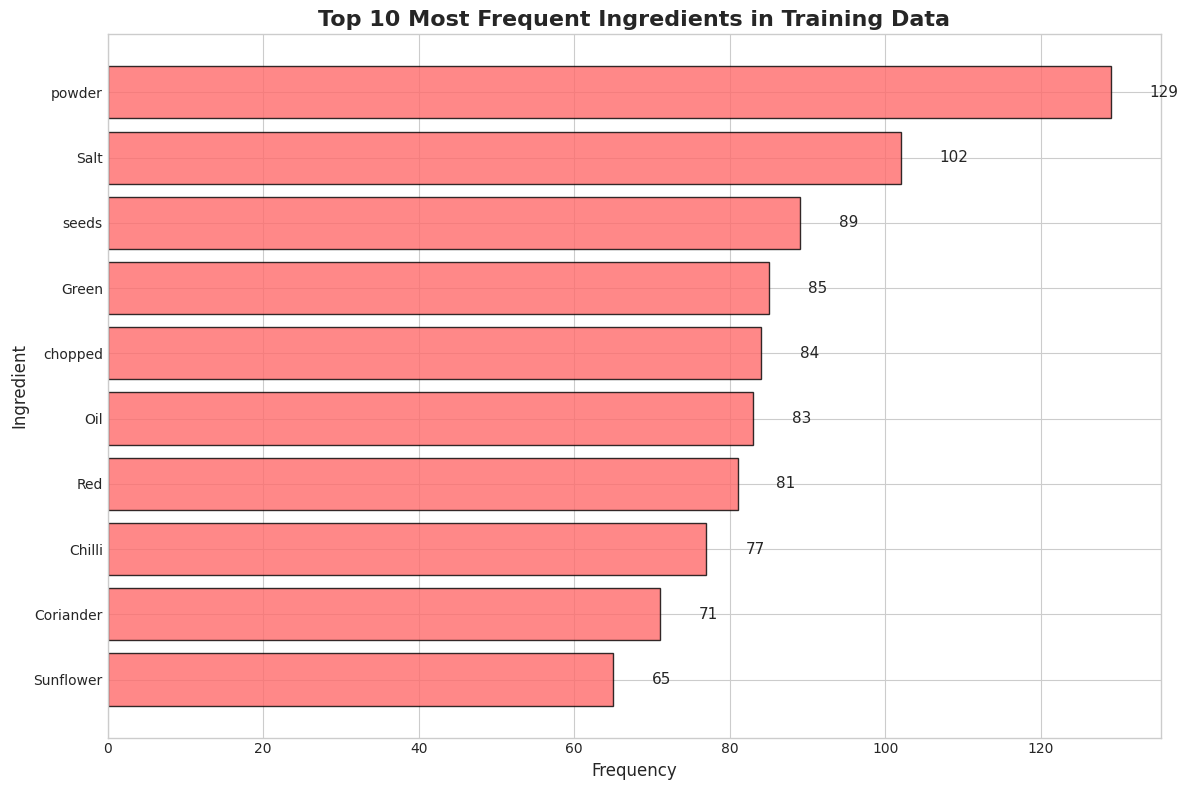

In [35]:
# plot the top frequent ingredients in training data

plot_top_items(top_10_ingredients, 'Ingredient', dataset_name)

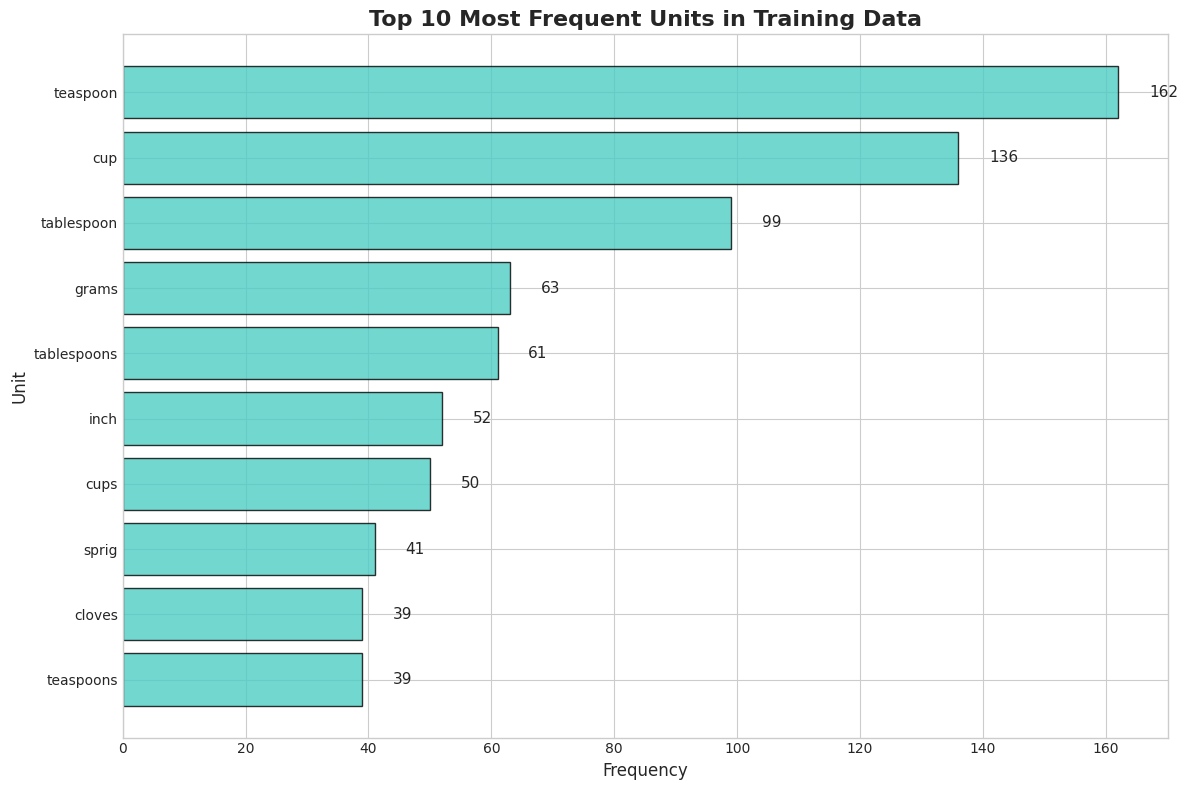

In [36]:
# plot the top frequent units in training data

plot_top_items(top_10_units, 'Unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [37]:
# initialise the dataset_name

dataset_name = 'Validation'
print(f"--- Switched to {dataset_name} Dataset for Analysis ---")

--- Switched to Validation Dataset for Analysis ---



=== Validation Dataset Token Extraction ===
Total input tokens: 2,876
Total pos tokens: 2,876
Length match: True

First 10 input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 pos tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


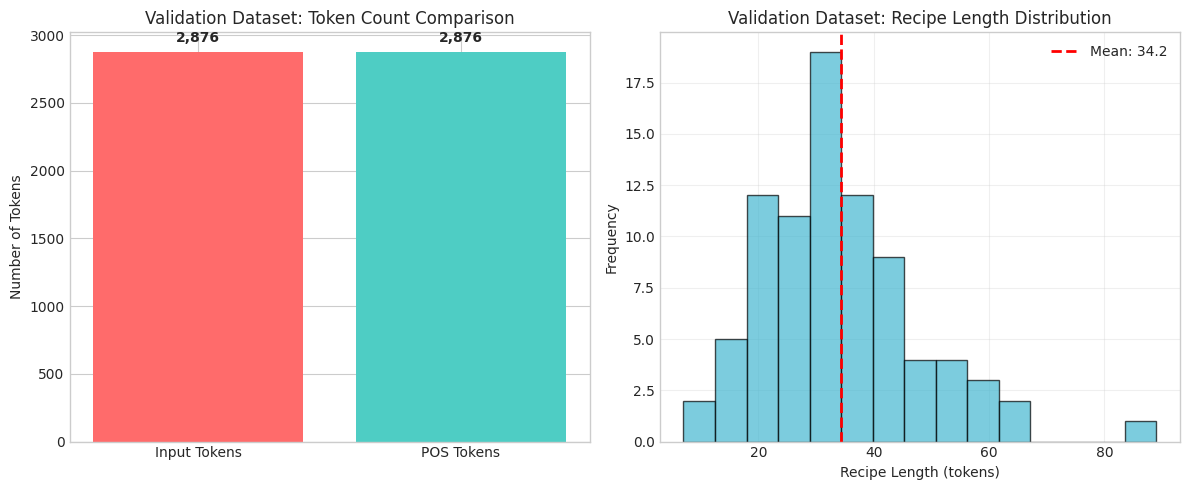

=== Token Categorization Summary ===
Total tokens processed: 2,876
Ingredients: 2,107 tokens
Units: 358 tokens
Quantities: 411 tokens
Total categorized: 2,876
--- Top 10 Most Frequent Ingredients in Validation Dataset ---


Ingredient  Frequency
0     powder         54
1       Salt         47
2        Oil         39
3        Red         39
4      seeds         36
5     Chilli         36
6    chopped         31
7      Green         30
8     Leaves         29
9  Coriander         27

--- Top 10 Most Frequent Units in Validation Dataset ---


Unit  Frequency
0     teaspoon         59
1          cup         57
2   tablespoon         32
3  tablespoons         32
4         cups         24
5        sprig         21
6         inch         20
7        grams         19
8    teaspoons         18
9       cloves         16

In [38]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

# Step 1: Extract and validate tokens from the validation dataframe
val_input_tokens, val_pos_tokens = extract_and_validate_tokens(val_df, dataset_name)

# Step 2: Categorize the validation tokens into labels
val_ingredients, val_units, val_quantities = categorize_tokens(val_input_tokens, val_pos_tokens)

# Step 3: Get the top 10 most frequent ingredients and units
top_10_val_ingredients = get_top_frequent_items(val_ingredients, 'Ingredient', dataset_name)
top_10_val_units = get_top_frequent_items(val_units, 'Unit', dataset_name)


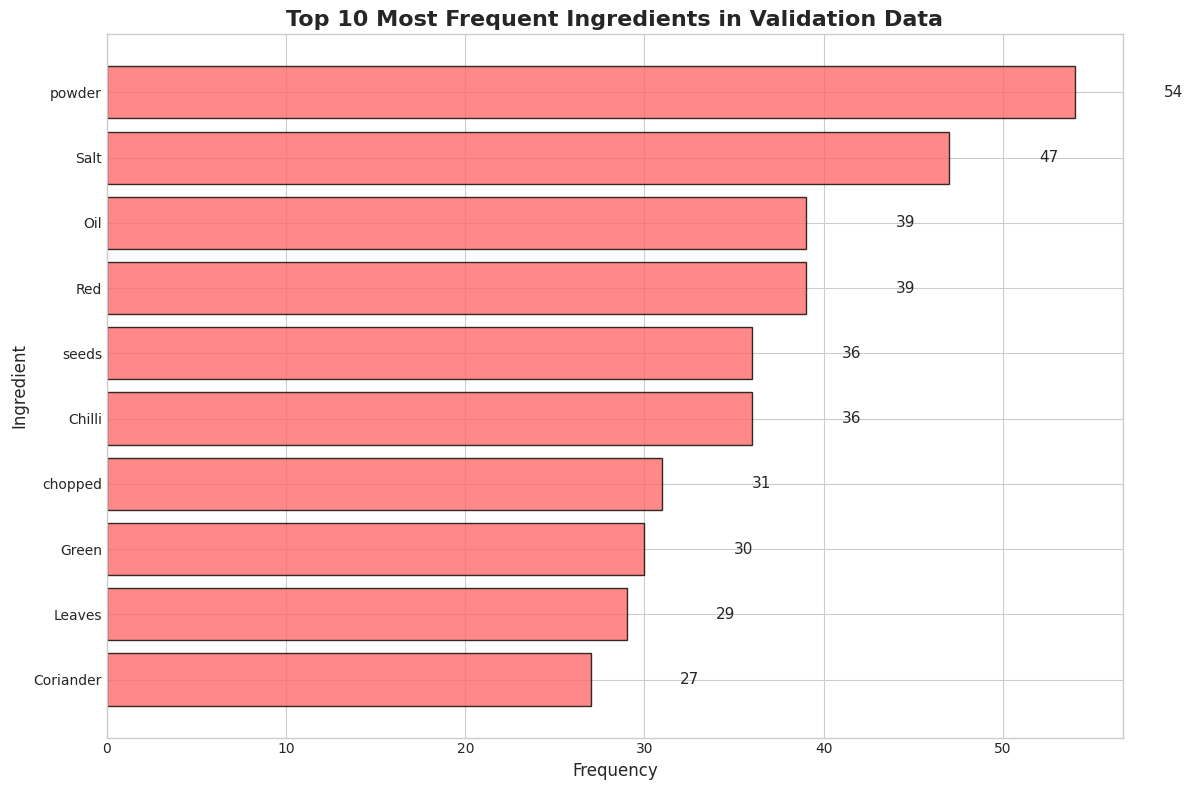

In [39]:
# plot the top frequent ingredients in validation data

plot_top_items(top_10_val_ingredients, 'Ingredient', dataset_name)

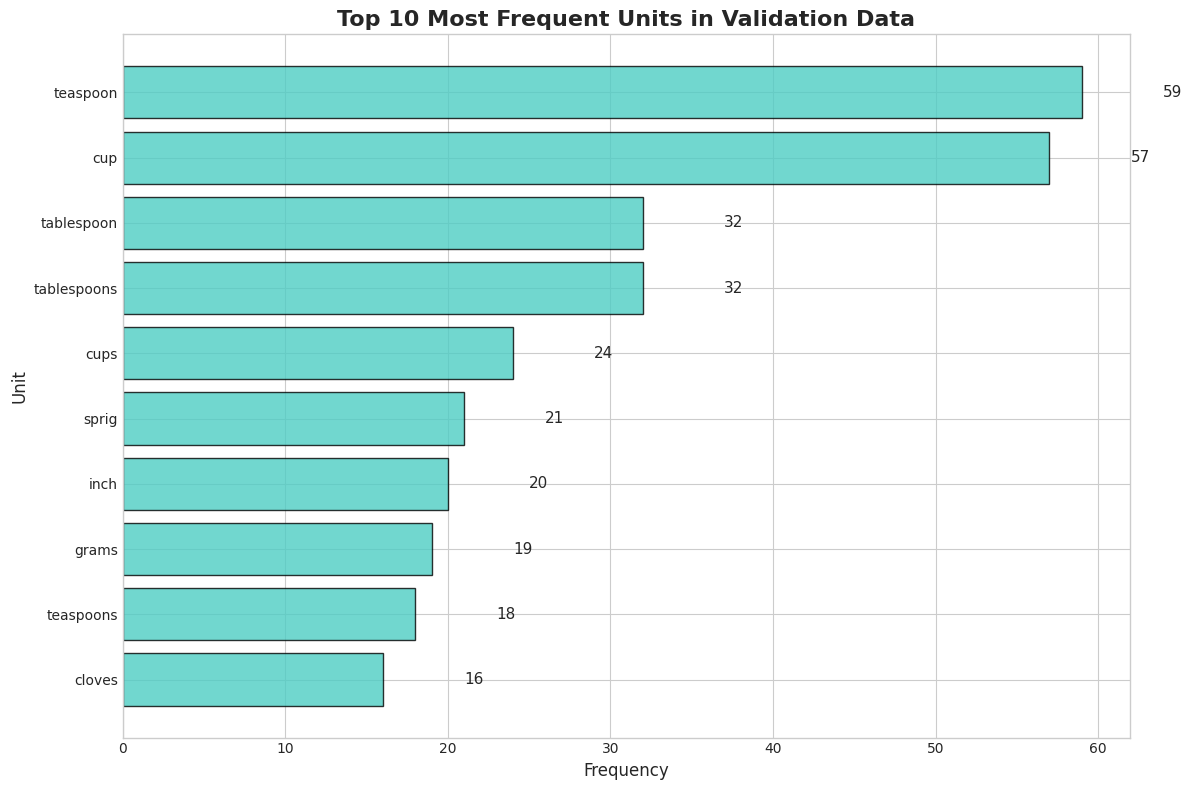

In [40]:
# plot the top frequent units in training data

plot_top_items(top_10_val_units, 'Unit', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [41]:
# define unit and quantity keywords along with quantity pattern

# --- Define Keyword Sets ---
unit_keywords = {
    'teaspoon', 'teaspoons', 'tsp', 't',
    'tablespoon', 'tablespoons', 'tbsp', 'tbs',
    'cup', 'cups',
    'gram', 'grams', 'g',
    'inch', 'inches',
    'sprig', 'sprigs',
    'clove', 'cloves',
    'liter', 'liters', 'l',
    'ml', 'kg',
    'pound', 'pounds', 'lb',
    'ounce', 'ounces', 'oz',
    'piece', 'pieces',
    'slice', 'slices',
    'can', 'cans',
    'bunch', 'pinch',
    'package', 'pkg',
    'stick', 'sticks'
}

quantity_keywords = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'half', 'quarter'
}

# --- Define Regex Pattern for Numerical Quantities ---
quantity_pattern = re.compile(r'^(?:\d+-\d+\/\d+|\d+\/\d+|\d+\.\d+|\d+-\d+|\d+)$')

In [42]:
# load spaCy model

try:
    nlp = spacy.load("en_core_web_sm")
    print("✓ spaCy model 'en_core_web_sm' loaded successfully.")
    SPACY_AVAILABLE = True
except OSError:
    print("✗ spaCy model not found. Using fallback approach without spaCy.")
    print("To install spaCy model, run: !python -m spacy download en_core_web_sm")
    nlp = None
    SPACY_AVAILABLE = False

print(f"Unit keywords count: {len(unit_keywords)}")
print(f"Quantity keywords count: {len(quantity_keywords)}")
print(f"Sample unit keywords: {list(unit_keywords)[:10]}")
print(f"Sample quantity keywords: {list(quantity_keywords)}")


✓ spaCy model 'en_core_web_sm' loaded successfully.
Unit keywords count: 42
Quantity keywords count: 12
Sample unit keywords: ['gram', 'stick', 'piece', 'tbs', 'teaspoon', 'sprig', 'package', 'slice', 'liter', 'can']
Sample quantity keywords: ['five', 'ten', 'four', 'seven', 'two', 'one', 'three', 'nine', 'six', 'half', 'eight', 'quarter']


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [43]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions


def word2features(sent, i):
    """
    Extracts a dictionary of features for a single token in a sentence.
    
    Args:
        sent (list): A list of tokens representing a recipe sentence.
        i (int): The index of the token in the sentence to extract features for.
        
    Returns:
        dict: A dictionary of features for the token at index i.
    """
    
# Process the entire sentence with spaCy ------------------------------------------------------------------------------------

    if SPACY_AVAILABLE and nlp:
        doc = nlp(" ".join(sent))
        # Ensure the doc and sent have the same length after tokenization
        if len(doc) != len(sent):
            # Fallback for tokenization mismatches
            token_doc = None
        else:
            token_doc = doc[i]
    else:
        token_doc = None
    
    token_text = sent[i]
    
# --- Core Features ------------------------------------------------------------------------------------

    features = {
        'bias': 1.0,
        'token': token_text.lower(),
        'lemma': token_doc.lemma_.lower() if token_doc else token_text.lower(),
        'pos_tag': token_doc.pos_ if token_doc else 'UNKNOWN',
        'tag': token_doc.tag_ if token_doc else 'UNKNOWN',
        'dep': token_doc.dep_ if token_doc else 'UNKNOWN',
        'shape': token_doc.shape_ if token_doc else 'UNKNOWN',
        'is_stop': token_doc.is_stop if token_doc else (token_text.lower() in {'a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}),
        'is_digit': token_text.isdigit(),
        'has_digit': any(char.isdigit() for char in token_text),
        'has_alpha': any(char.isalpha() for char in token_text),
        'hyphenated': '-' in token_text,
        'slash_present': '/' in token_text,
        'is_title': token_text.istitle(),
        'is_upper': token_text.isupper(),
        'is_punct': token_doc.is_punct if token_doc else (token_text in '.,!?;:"()[]{}'),
    }
    
# --- Improved Quantity & Unit Detection ---------------------------------------------------------------------


    is_numeric_match = bool(quantity_pattern.match(token_text))
    features.update({
        'is_quantity': is_numeric_match or token_text.lower() in quantity_keywords,
        'is_unit': token_text.lower() in unit_keywords,
        'is_numeric': is_numeric_match,
        'is_fraction': '/' in token_text and bool(re.match(r'^\d+\/\d+$', token_text)),
        'is_decimal': '.' in token_text and bool(re.match(r'^\d+\.\d+$', token_text)),
        'preceding_word': sent[i-1] if i > 0 else '<BOS>',
        'following_word': sent[i+1] if i < len(sent)-1 else '<EOS>',
    })
    
# --- Contextual Features ---------------------------------------------------------------------------------------

    # Features for the PREVIOUS token
    if i == 0:
        features['BOS'] = True
    else:
        prev_token_text = sent[i-1]
        features.update({
            'prev_token': prev_token_text.lower(),
            'prev_is_quantity': bool(quantity_pattern.match(prev_token_text)) or (prev_token_text.lower() in quantity_keywords),
            'prev_is_digit': prev_token_text.isdigit(),
        })
    
    # Features for the NEXT token
    if i == len(sent) - 1:
        features['EOS'] = True
    else:
        next_token_text = sent[i+1]
        is_next_ingredient = not (
            bool(quantity_pattern.match(next_token_text)) or
            next_token_text.lower() in quantity_keywords or
            next_token_text.lower() in unit_keywords
        )
        features.update({
            'next_token': next_token_text.lower(),
            'next_is_unit': next_token_text.lower() in unit_keywords,
            'next_is_ingredient': is_next_ingredient
        })
    
    return features


# --- Example Usage ---
print("\n--- Example of Feature Extraction ---")
example_sentence = X_train[0]
example_index = 2

print(f"Example Sentence: '{' '.join(example_sentence)}'")
print(f"Token being analyzed: '{example_sentence[example_index]}' at index {example_index}")

# Extract features for the example token
example_features = word2features(example_sentence, example_index)

# Display the features in a structured DataFrame
features_df = pd.DataFrame(list(example_features.items()), columns=['Feature', 'Value'])
print(f"\nExtracted {len(example_features)} features:")
display(features_df)


--- Example of Feature Extraction ---
Example Sentence: '250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric'
Token being analyzed: 'Okra' at index 2

Extracted 29 features:


Feature  Value
0                 bias    1.0
1                token   okra
2                lemma   okra
3              pos_tag  PROPN
4                  tag    NNP
5                  dep   nmod
6                shape   Xxxx
7              is_stop  False
8             is_digit  False
9            has_digit  False
10           has_alpha   True
11          hyphenated  False
12       slash_present  False
13            is_title   True
14            is_upper  False
15            is_punct  False
16         is_quantity  False
17             is_unit  False
18          is_numeric  False
19         is_fraction  False
20          is_decimal  False
21      preceding_word  grams
22      following_word    Oil
23          prev_token  grams
24    prev_is_quantity  False
25       prev_is_digit  False
26          next_token    oil
27        next_is_unit  False
28  next_is_ingredient   True

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

--- Demonstration of sent2features Function ---
Sample Recipe: '250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric'
Recipe Length: 31 tokens
Generated features for 31 tokens


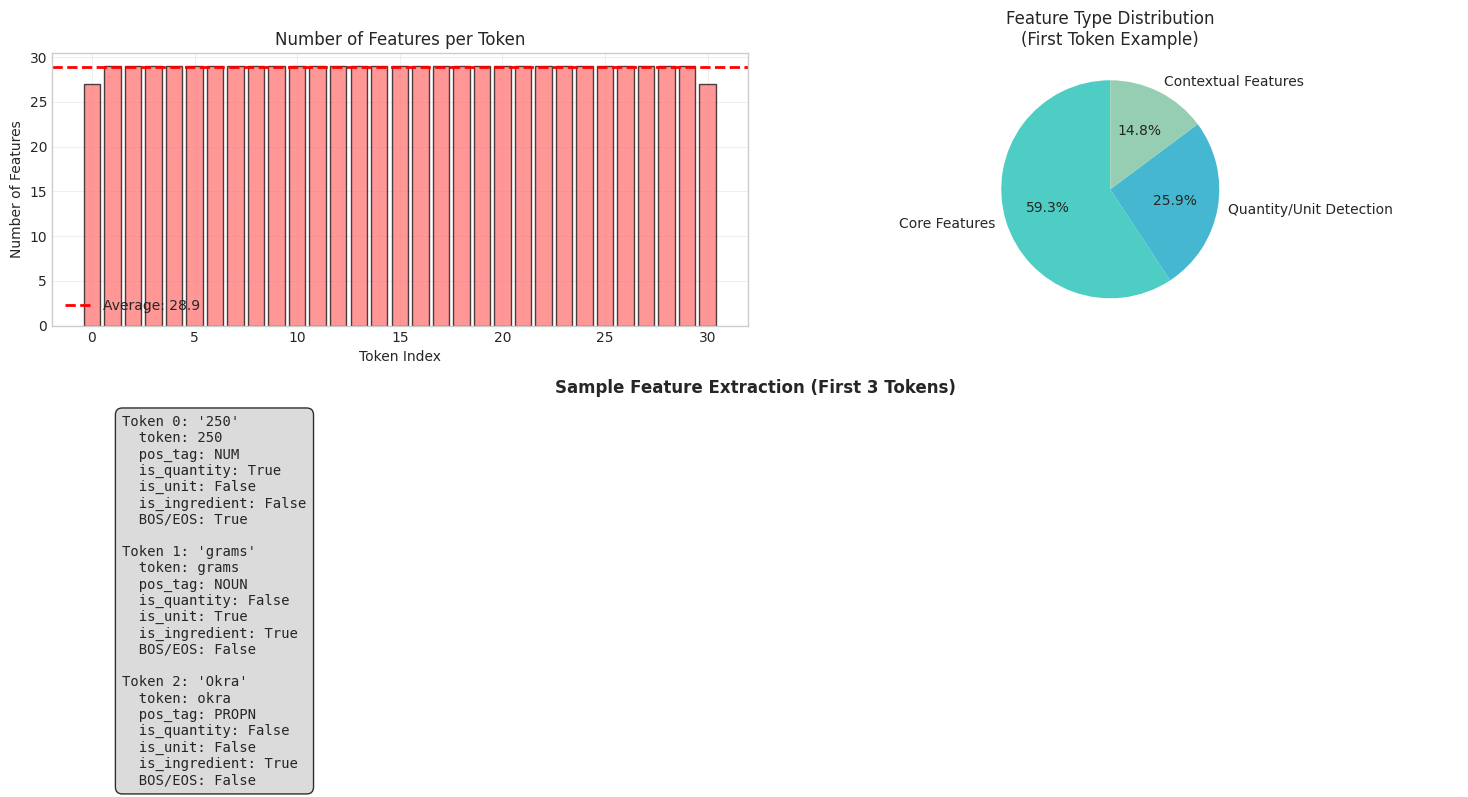


--- Detailed Feature Analysis ---
Total recipes in training set: 196
Sample recipe features extracted: 31 feature dictionaries
Each feature dictionary contains: 27 features

Feature keys in each token:
   1. bias
   2. token
   3. lemma
   4. pos_tag
   5. tag
   6. dep
   7. shape
   8. is_stop
   9. is_digit
  10. has_digit
  11. has_alpha
  12. hyphenated
  13. slash_present
  14. is_title
  15. is_upper
  16. is_punct
  17. is_quantity
  18. is_unit
  19. is_numeric
  20. is_fraction
  21. is_decimal
  22. preceding_word
  23. following_word
  24. BOS
  25. next_token
  26. next_is_unit
  27. next_is_ingredient

--- Verification ---
✓ Function processes 31 tokens
✓ Generates 31 feature dictionaries
✓ Each dictionary has 27 features
✓ All tokens processed: True

--- Performance Insight ---
Estimated total features for training set: 164,052


In [44]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features


def sent2features(sent):
    """
    Generate feature dictionaries for each token in a sentence (recipe).
    
    Args:
        sent (list): A list of tokens representing a recipe sentence.
        
    Returns:
        list: A list of feature dictionaries, one for each token in the sentence.
    """
    return [word2features(sent, i) for i in range(len(sent))]

# --- Example Usage and Visualization ---
print("--- Demonstration of sent2features Function ---")

# Select a sample recipe for demonstration
sample_recipe = X_train[0]
print(f"Sample Recipe: '{' '.join(sample_recipe)}'")
print(f"Recipe Length: {len(sample_recipe)} tokens")

# Generate features for the entire recipe
recipe_features = sent2features(sample_recipe)
print(f"Generated features for {len(recipe_features)} tokens")

# --- Visualization of Feature Extraction Process ---
plt.figure(figsize=(15, 8))

# Subplot 1: Token-by-token analysis
plt.subplot(2, 2, 1)
token_indices = list(range(len(sample_recipe)))
feature_counts = [len(features) for features in recipe_features]

plt.bar(token_indices, feature_counts, color='#FF6B6B', alpha=0.7, edgecolor='black')
plt.title('Number of Features per Token')
plt.xlabel('Token Index')
plt.ylabel('Number of Features')
plt.grid(True, alpha=0.3)

# Add average line
avg_features = np.mean(feature_counts)
plt.axhline(y=avg_features, color='red', linestyle='--', linewidth=2, 
            label=f'Average: {avg_features:.1f}')
plt.legend()

# Subplot 2: Feature type distribution for first few tokens
plt.subplot(2, 2, 2)
feature_types = ['Core Features', 'Quantity/Unit Detection', 'Contextual Features']

# Count different types of features for the first token as example
first_token_features = recipe_features[0]
core_count = sum(1 for key in first_token_features.keys() if key in 
                ['bias', 'token', 'lemma', 'pos_tag', 'tag', 'dep', 'shape', 
                 'is_stop', 'is_digit', 'has_digit', 'has_alpha', 'hyphenated', 
                 'slash_present', 'is_title', 'is_upper', 'is_punct'])
quantity_count = sum(1 for key in first_token_features.keys() if key in 
                    ['is_quantity', 'is_unit', 'is_numeric', 'is_fraction', 
                     'is_decimal', 'preceding_word', 'following_word'])
contextual_count = sum(1 for key in first_token_features.keys() if key in 
                      ['BOS', 'EOS', 'prev_token', 'prev_is_quantity', 'prev_is_digit',
                       'next_token', 'next_is_unit', 'next_is_ingredient'])

counts = [core_count, quantity_count, contextual_count]
colors = ['#4ECDC4', '#45B7D1', '#96CEB4']

plt.pie(counts, labels=feature_types, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Feature Type Distribution\n(First Token Example)')

# Subplot 3: Sample of extracted features for first 3 tokens
plt.subplot(2, 1, 2)
sample_tokens = sample_recipe[:3]
sample_features_display = []

for i, (token, features) in enumerate(zip(sample_tokens, recipe_features[:3])):
    # Select key features for display
    key_features = {
        'token': features.get('token', ''),
        'pos_tag': features.get('pos_tag', ''),
        'is_quantity': features.get('is_quantity', False),
        'is_unit': features.get('is_unit', False),
        'is_ingredient': features.get('next_is_ingredient', False),
        'BOS/EOS': features.get('BOS', features.get('EOS', False))
    }
    sample_features_display.append(f"Token {i}: '{token}'\n" + 
                                   '\n'.join([f"  {k}: {v}" for k, v in key_features.items()]))

# Display as text
feature_text = '\n\n'.join(sample_features_display)
plt.text(0.05, 0.95, feature_text, fontsize=10, verticalalignment='top',
         fontfamily='monospace', 
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
plt.title('Sample Feature Extraction (First 3 Tokens)', fontsize=12, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Detailed Analysis of Feature Extraction ---
print("\n--- Detailed Feature Analysis ---")
print(f"Total recipes in training set: {len(X_train)}")
print(f"Sample recipe features extracted: {len(recipe_features)} feature dictionaries")
print(f"Each feature dictionary contains: {len(recipe_features[0])} features")

# Show feature keys for verification
print(f"\nFeature keys in each token:")
feature_keys = list(recipe_features[0].keys())
for i, key in enumerate(feature_keys, 1):
    print(f"  {i:2d}. {key}")

# Verification that function works correctly
print(f"\n--- Verification ---")
print(f"✓ Function processes {len(sample_recipe)} tokens")
print(f"✓ Generates {len(recipe_features)} feature dictionaries")
print(f"✓ Each dictionary has {len(recipe_features[0])} features")
print(f"✓ All tokens processed: {len(sample_recipe) == len(recipe_features)}")

# Performance insight
print(f"\n--- Performance Insight ---")
estimated_features_per_recipe = len(sample_recipe) * len(recipe_features[0])
total_estimated_features = len(X_train) * estimated_features_per_recipe
print(f"Estimated total features for training set: {total_estimated_features:,}")


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [45]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

print("--- Generating features for training and validation sets ---")
print("This may take a moment...")

# Apply the sent2features function to each recipe in the training set
X_train_features = [sent2features(s) for s in X_train]
print(f"✓ Generated features for {len(X_train_features)} training recipes.")

# Apply the sent2features function to each recipe in the validation set
X_val_features = [sent2features(s) for s in X_val]
print(f"✓ Generated features for {len(X_val_features)} validation recipes.")


--- Generating features for training and validation sets ---
This may take a moment...
✓ Generated features for 196 training recipes.
✓ Generated features for 84 validation recipes.


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [46]:
# Convert labels into list as y_train_labels and y_val_labels

# The y_train and y_val variables are already in the desired list format.
# We assign them to new variables as per the instruction.
y_train_labels = y_train
y_val_labels = y_val

print("--- Assigned labels for training and validation sets ---")
print(f"✓ y_train_labels contains {len(y_train_labels)} label sequences.")
print(f"✓ y_val_labels contains {len(y_val_labels)} label sequences.")


--- Assigned labels for training and validation sets ---
✓ y_train_labels contains 196 label sequences.
✓ y_val_labels contains 84 label sequences.


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [47]:
# print the length of train features and labels

print("--- Training Set Dimensions ---")
print(f"Number of training recipes (features): {len(X_train_features)}")
print(f"Number of training recipes (labels):   {len(y_train_labels)}")

# Verification
if len(X_train_features) == len(y_train_labels):
    print("✓ Verification successful: Feature and label counts match for the training set.")
else:
    print("✗ Verification failed: Mismatch in feature and label counts for the training set.")


--- Training Set Dimensions ---
Number of training recipes (features): 196
Number of training recipes (labels):   196
✓ Verification successful: Feature and label counts match for the training set.



--- Validation Set Dimensions ---
Number of validation recipes (features): 84
Number of validation recipes (labels):   84
✓ Verification successful: Feature and label counts match for the validation set.


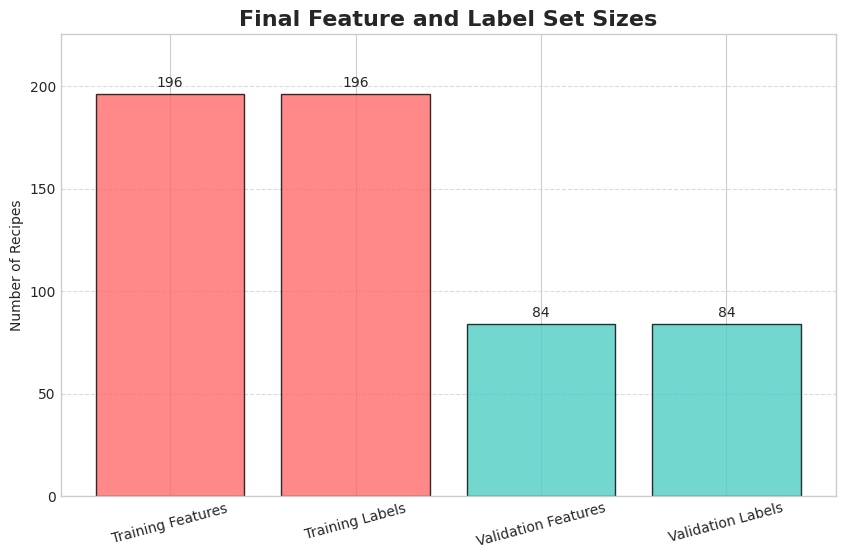

In [48]:
# print the length of validation features and labels

print("\n--- Validation Set Dimensions ---")
print(f"Number of validation recipes (features): {len(X_val_features)}")
print(f"Number of validation recipes (labels):   {len(y_val_labels)}")

# Verification
if len(X_val_features) == len(y_val_labels):
    print("✓ Verification successful: Feature and label counts match for the validation set.")
else:
    print("✗ Verification failed: Mismatch in feature and label counts for the validation set.")

# --- Visualization of Dataset Sizes ---
plt.figure(figsize=(10, 6))
categories = ['Training Features', 'Training Labels', 'Validation Features', 'Validation Labels']
counts = [len(X_train_features), len(y_train_labels), len(X_val_features), len(y_val_labels)]
colors = ['#FF6B6B', '#FF6B6B', '#4ECDC4', '#4ECDC4']

bars = plt.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)
plt.ylabel('Number of Recipes')
plt.title('Final Feature and Label Set Sizes', fontsize=16, fontweight='bold')
plt.xticks(rotation=15)

# Add count labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 2, yval, ha='center', va='bottom')

plt.ylim(0, max(counts) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

--- Flattening Training Labels ---
Original y_train_labels structure: 196 recipes
Flattened y_train_flat structure: 7114 individual labels
Sample original (first recipe): ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity']...
Sample flattened (first 10): ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


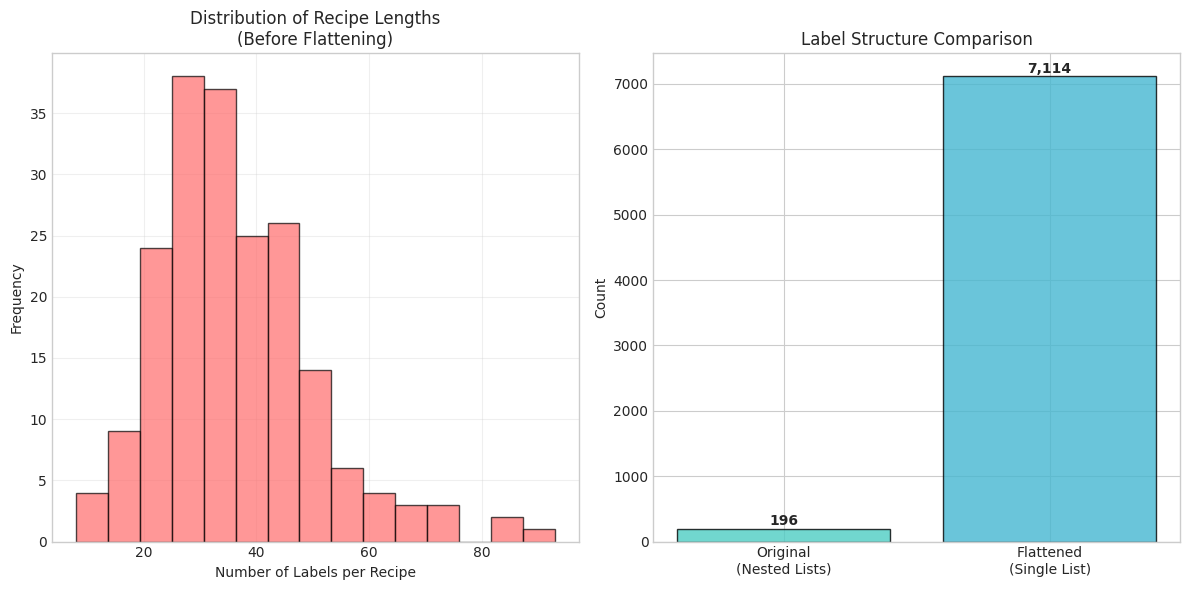

In [49]:
# Flatten labels in y_train

# Flatten the nested list structure of y_train into a single list
y_train_flat = []
for recipe_labels in y_train_labels:
    y_train_flat.extend(recipe_labels)

print("--- Flattening Training Labels ---")
print(f"Original y_train_labels structure: {len(y_train_labels)} recipes")
print(f"Flattened y_train_flat structure: {len(y_train_flat)} individual labels")
print(f"Sample original (first recipe): {y_train_labels[0][:5]}...")
print(f"Sample flattened (first 10): {y_train_flat[:10]}")

# Visualization of flattening process
plt.figure(figsize=(12, 6))

# Show the distribution of recipe lengths before flattening
recipe_lengths = [len(recipe) for recipe in y_train_labels]

plt.subplot(1, 2, 1)
plt.hist(recipe_lengths, bins=15, color='#FF6B6B', alpha=0.7, edgecolor='black')
plt.title('Distribution of Recipe Lengths\n(Before Flattening)')
plt.xlabel('Number of Labels per Recipe')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show the flattening concept
plt.subplot(1, 2, 2)
categories = ['Original\n(Nested Lists)', 'Flattened\n(Single List)']
values = [len(y_train_labels), len(y_train_flat)]
colors = ['#4ECDC4', '#45B7D1']

bars = plt.bar(categories, values, color=colors, edgecolor='black', alpha=0.8)
plt.title('Label Structure Comparison')
plt.ylabel('Count')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

--- Label Frequency Analysis ---
Total samples (individual labels): 7,114
Number of unique labels: 3

Label distribution:
  quantity    : 980 (13.78%)
  unit        : 811 (11.40%)
  ingredient  : 5,323 (74.82%)

Verification:
✓ Sum of label counts equals flattened list length: True


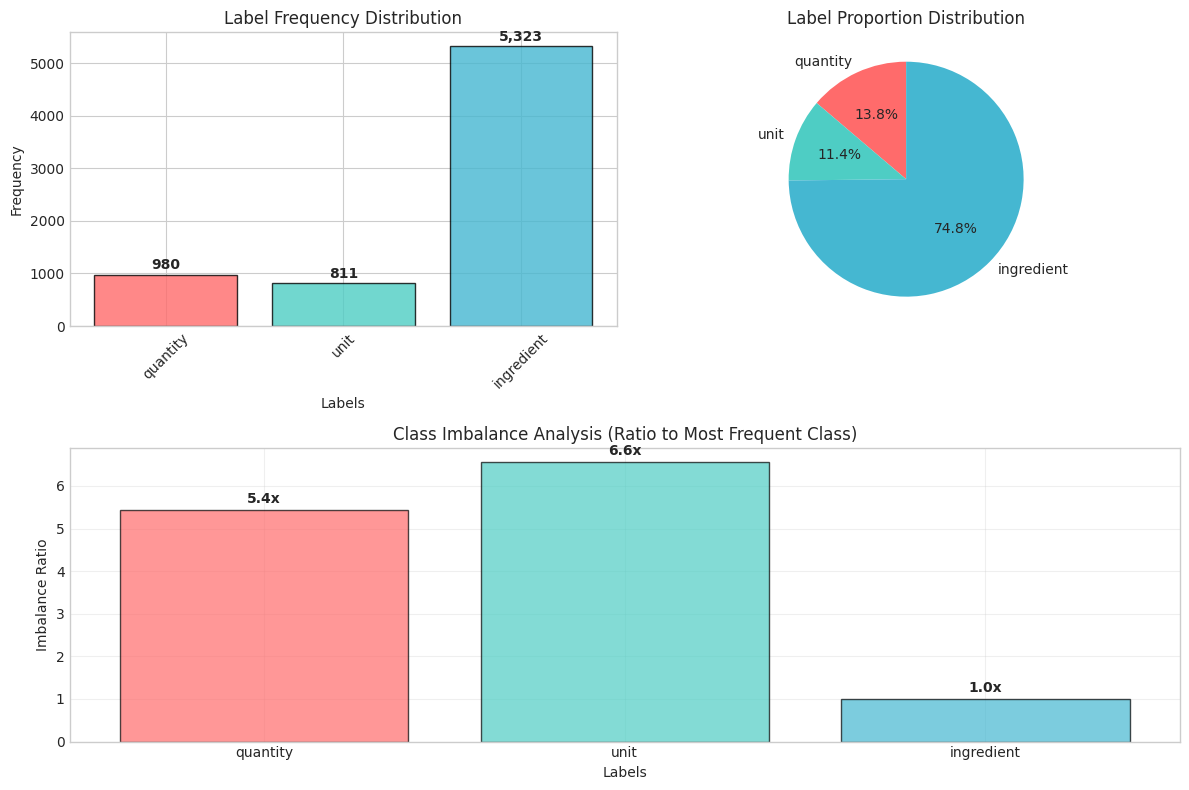


--- Class Imbalance Summary ---
quantity    : 5.4x less frequent than most common class
unit        : 6.6x less frequent than most common class
ingredient  : 1.0x less frequent than most common class


In [50]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

# Count the frequency of each label in the flattened training data
label_counts = Counter(y_train_flat)

# Calculate total samples by summing all label frequencies
total_samples = sum(label_counts.values())

print("--- Label Frequency Analysis ---")
print(f"Total samples (individual labels): {total_samples:,}")
print(f"Number of unique labels: {len(label_counts)}")
print("\nLabel distribution:")
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"  {label:12}: {count:,} ({percentage:.2f}%)")

# Verification
print(f"\nVerification:")
print(f"✓ Sum of label counts equals flattened list length: {sum(label_counts.values()) == len(y_train_flat)}")

# Visualization of label distribution
plt.figure(figsize=(12, 8))

# Subplot 1: Bar chart
plt.subplot(2, 2, 1)
labels = list(label_counts.keys())
counts = list(label_counts.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(labels, counts, color=colors, edgecolor='black', alpha=0.8)
plt.title('Label Frequency Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: Pie chart
plt.subplot(2, 2, 2)
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Label Proportion Distribution')

# Subplot 3: Class imbalance analysis
plt.subplot(2, 1, 2)
percentages = [(count/total_samples)*100 for count in counts]

# Create imbalance ratio analysis
max_count = max(counts)
imbalance_ratios = [max_count/count for count in counts]

x_pos = range(len(labels))
bars = plt.bar(x_pos, imbalance_ratios, color=colors, alpha=0.7, edgecolor='black')
plt.title('Class Imbalance Analysis (Ratio to Most Frequent Class)')
plt.xlabel('Labels')
plt.ylabel('Imbalance Ratio')
plt.xticks(x_pos, labels)

# Add ratio labels
for bar, ratio in zip(bars, imbalance_ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{ratio:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n--- Class Imbalance Summary ---")
for label, ratio in zip(labels, imbalance_ratios):
    print(f"{label:12}: {ratio:.1f}x less frequent than most common class")


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [51]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

# Calculate inverse frequency weights
# Formula: weight = total_samples / (n_classes * frequency)
n_classes = len(label_counts)
weight_dict = {}

for label, count in label_counts.items():
    weight_dict[label] = total_samples / (n_classes * count)

print("--- Initial Class Weights (Inverse Frequency Method) ---")
for label, weight in weight_dict.items():
    print(f"{label:12}: {weight:.4f}")


--- Initial Class Weights (Inverse Frequency Method) ---
quantity    : 2.4197
unit        : 2.9240
ingredient  : 0.4455



--- Penalizing 'ingredient' label ---
Original weight: 0.4455
Penalized weight: 0.2227
Penalty factor: 0.5

--- Final Class Weights ---
quantity    : 2.4197
unit        : 2.9240
ingredient  : 0.2227


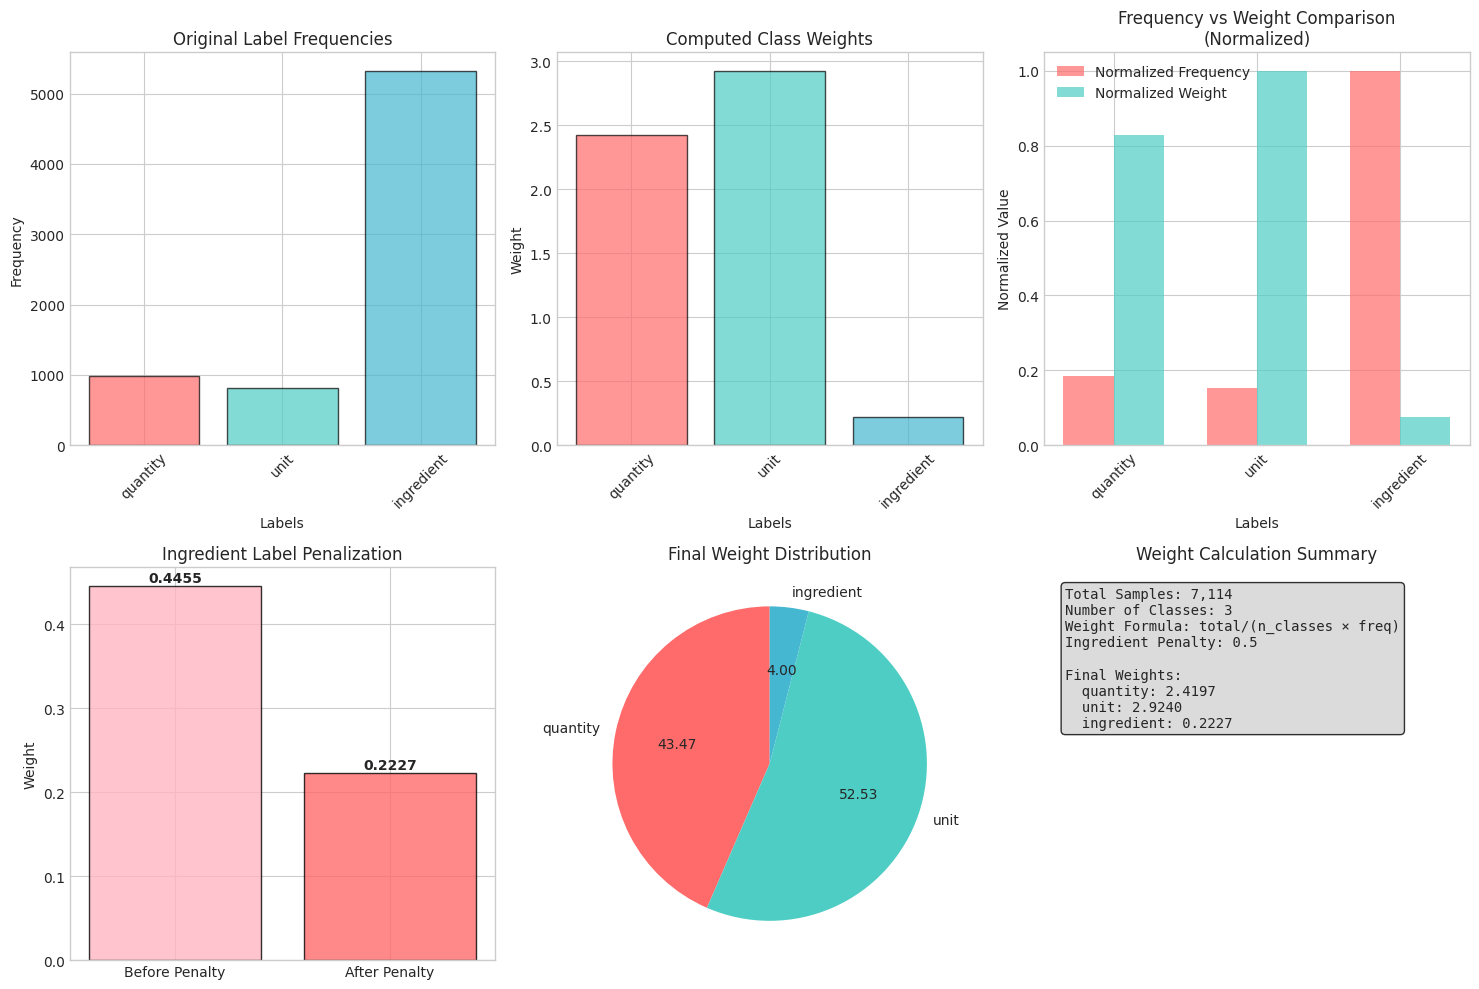


--- Weight Calculation Verification ---
✓ All labels have weights assigned: True
✓ Ingredient label penalized: True
✓ Weight dictionary ready for CRF model


In [52]:
# penalise ingredient label

# Since ingredient is the most frequent class, we further reduce its weight to address class imbalance
penalty_factor = 0.5  # Reduce ingredient weight by 50%
if 'ingredient' in weight_dict:
    original_weight = weight_dict['ingredient']
    weight_dict['ingredient'] = original_weight * penalty_factor
    print(f"\n--- Penalizing 'ingredient' label ---")
    print(f"Original weight: {original_weight:.4f}")
    print(f"Penalized weight: {weight_dict['ingredient']:.4f}")
    print(f"Penalty factor: {penalty_factor}")

print(f"\n--- Final Class Weights ---")
for label, weight in weight_dict.items():
    print(f"{label:12}: {weight:.4f}")

# Visualization of weight calculation process
plt.figure(figsize=(15, 10))

# Subplot 1: Original frequencies vs weights
plt.subplot(2, 3, 1)
labels = list(label_counts.keys())
frequencies = list(label_counts.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.bar(labels, frequencies, color=colors, alpha=0.7, edgecolor='black')
plt.title('Original Label Frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Subplot 2: Computed weights
plt.subplot(2, 3, 2)
weights = [weight_dict[label] for label in labels]
plt.bar(labels, weights, color=colors, alpha=0.7, edgecolor='black')
plt.title('Computed Class Weights')
plt.xlabel('Labels')
plt.ylabel('Weight')
plt.xticks(rotation=45)

# Subplot 3: Weight comparison
plt.subplot(2, 3, 3)
x_pos = range(len(labels))
width = 0.35

# Normalize frequencies for comparison (scale to 0-1)
norm_frequencies = [f/max(frequencies) for f in frequencies]
norm_weights = [w/max(weights) for w in weights]

plt.bar([x - width/2 for x in x_pos], norm_frequencies, width, 
        label='Normalized Frequency', color='#FF6B6B', alpha=0.7)
plt.bar([x + width/2 for x in x_pos], norm_weights, width,
        label='Normalized Weight', color='#4ECDC4', alpha=0.7)

plt.title('Frequency vs Weight Comparison\n(Normalized)')
plt.xlabel('Labels')
plt.ylabel('Normalized Value')
plt.xticks(x_pos, labels, rotation=45)
plt.legend()

# Subplot 4: Impact of penalization
plt.subplot(2, 3, 4)
# Show before and after weights for ingredient
if 'ingredient' in weight_dict:
    before_penalty = weight_dict['ingredient'] / penalty_factor
    after_penalty = weight_dict['ingredient']
    
    categories = ['Before Penalty', 'After Penalty']
    values = [before_penalty, after_penalty]
    colors_penalty = ['#FFB6C1', '#FF6B6B']
    
    bars = plt.bar(categories, values, color=colors_penalty, edgecolor='black', alpha=0.8)
    plt.title('Ingredient Label Penalization')
    plt.ylabel('Weight')
    
    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Subplot 5: Final weight distribution
plt.subplot(2, 3, 5)
final_weights = list(weight_dict.values())
plt.pie(final_weights, labels=labels, colors=colors, autopct='%1.2f', startangle=90)
plt.title('Final Weight Distribution')

# Subplot 6: Weight effectiveness summary
plt.subplot(2, 3, 6)
effectiveness_data = [
    f"Total Samples: {total_samples:,}",
    f"Number of Classes: {n_classes}",
    f"Weight Formula: total/(n_classes × freq)",
    f"Ingredient Penalty: {penalty_factor}",
    "",
    "Final Weights:",
    *[f"  {label}: {weight:.4f}" for label, weight in weight_dict.items()]
]

plt.text(0.05, 0.95, '\n'.join(effectiveness_data), fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
plt.title('Weight Calculation Summary')
plt.axis('off')

plt.tight_layout()
plt.show()

# Final verification
print(f"\n--- Weight Calculation Verification ---")
print(f"✓ All labels have weights assigned: {len(weight_dict) == len(label_counts)}")
print(f"✓ Ingredient label penalized: {'ingredient' in weight_dict}")
print(f"✓ Weight dictionary ready for CRF model")

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





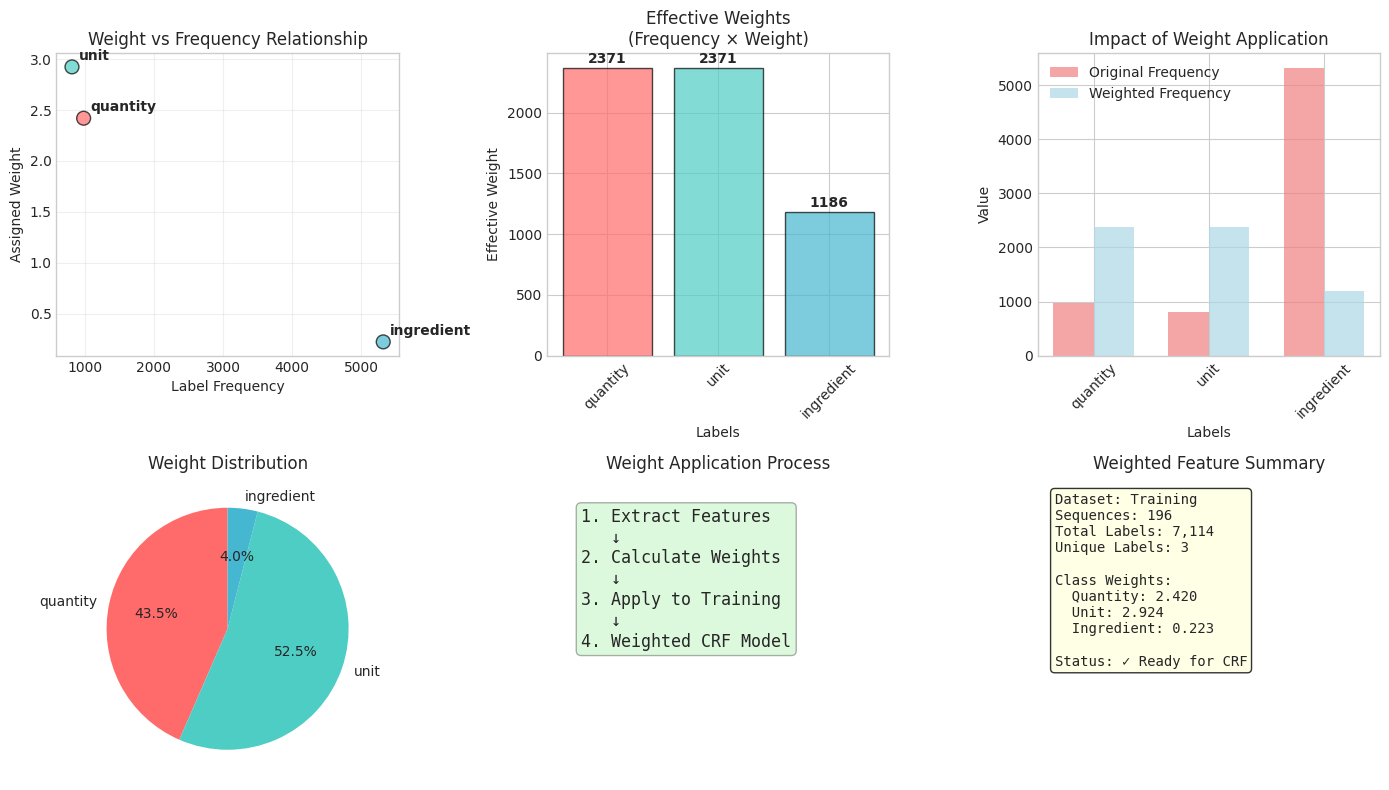


--- Function Definition Complete ---
✓ extract_features_with_class_weights function ready
✓ Supports weighted CRF training
✓ Includes validation and summary features


In [53]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)


def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extract features along with class weights for weighted CRF training.
    
    This function validates the input data and prepares features for weighted training
    by ensuring compatibility between features, labels, and weight dictionary.
    
    Args:
        X (list): List of feature sequences (already extracted using sent2features)
        y (list): List of label sequences corresponding to X
        weight_dict (dict): Dictionary mapping labels to their computed weights
        
    Returns:
        tuple: (weighted_features, labels, weight_summary)
            - weighted_features: Features ready for weighted training
            - labels: Validated labels
            - weight_summary: Summary of weight application
    """
    
    print("--- Extracting Features with Class Weights ---")
    
    # Validation checks
    if len(X) != len(y):
        raise ValueError(f"Mismatch: {len(X)} feature sequences vs {len(y)} label sequences")
    
    # Validate that all labels in the dataset have corresponding weights
    all_labels_in_data = set()
    for label_seq in y:
        all_labels_in_data.update(label_seq)
    
    missing_weights = all_labels_in_data - set(weight_dict.keys())
    if missing_weights:
        raise ValueError(f"Missing weights for labels: {missing_weights}")
    
    print(f"✓ Validated {len(X)} sequences")
    print(f"✓ All {len(all_labels_in_data)} unique labels have weights")
    
    # The features remain unchanged for CRF - weights are applied during training
    # We return the original features along with validation information
    weighted_features = X
    
    # Create weight application summary
    weight_summary = {
        'total_sequences': len(X),
        'total_labels_in_data': len(all_labels_in_data),
        'weight_coverage': len(all_labels_in_data & set(weight_dict.keys())),
        'weights_applied': weight_dict.copy(),
        'validation_passed': True
    }
    
    # Calculate weight distribution statistics
    flat_labels = [label for seq in y for label in seq]
    label_freq = Counter(flat_labels)
    
    print(f"\n--- Weight Application Summary ---")
    for label in all_labels_in_data:
        freq = label_freq[label]
        weight = weight_dict[label]
        effective_weight = freq * weight
        print(f"{label:12}: freq={freq:4d}, weight={weight:.4f}, effective={effective_weight:.2f}")
    
    return weighted_features, y, weight_summary

# Visualization of the weight application concept
plt.figure(figsize=(14, 8))

# Subplot 1: Weight vs Frequency relationship
plt.subplot(2, 3, 1)
labels = list(weight_dict.keys())
weights = list(weight_dict.values())
frequencies = [label_counts[label] for label in labels]

plt.scatter(frequencies, weights, c=['#FF6B6B', '#4ECDC4', '#45B7D1'], s=100, alpha=0.7, edgecolors='black')
for i, label in enumerate(labels):
    plt.annotate(label, (frequencies[i], weights[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold')

plt.xlabel('Label Frequency')
plt.ylabel('Assigned Weight')
plt.title('Weight vs Frequency Relationship')
plt.grid(True, alpha=0.3)

# Subplot 2: Effective weight calculation
plt.subplot(2, 3, 2)
effective_weights = [freq * weight_dict[label] for label, freq in zip(labels, frequencies)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(labels, effective_weights, color=colors, alpha=0.7, edgecolor='black')
plt.title('Effective Weights\n(Frequency × Weight)')
plt.xlabel('Labels')
plt.ylabel('Effective Weight')
plt.xticks(rotation=45)

# Add value labels
for bar, eff_weight in zip(bars, effective_weights):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{eff_weight:.0f}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Before and after weight comparison
plt.subplot(2, 3, 3)
x_pos = range(len(labels))
width = 0.35

plt.bar([x - width/2 for x in x_pos], frequencies, width, 
        label='Original Frequency', color='lightcoral', alpha=0.7)
plt.bar([x + width/2 for x in x_pos], effective_weights, width,
        label='Weighted Frequency', color='lightblue', alpha=0.7)

plt.title('Impact of Weight Application')
plt.xlabel('Labels')
plt.ylabel('Value')
plt.xticks(x_pos, labels, rotation=45)
plt.legend()

# Subplot 4: Weight distribution pie chart
plt.subplot(2, 3, 4)
weight_proportions = [w/sum(weights) for w in weights]
plt.pie(weight_proportions, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Weight Distribution')

# Subplot 5: Process flow diagram
plt.subplot(2, 3, 5)
process_steps = [
    "1. Extract Features",
    "   ↓",
    "2. Calculate Weights", 
    "   ↓",
    "3. Apply to Training",
    "   ↓", 
    "4. Weighted CRF Model"
]

plt.text(0.1, 0.9, '\n'.join(process_steps), fontsize=12, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.3))
plt.title('Weight Application Process')
plt.axis('off')

# Subplot 6: Key metrics
plt.subplot(2, 3, 6)
metrics_text = [
    f"Dataset: Training",
    f"Sequences: {len(X_train_features)}",
    f"Total Labels: {sum(label_counts.values()):,}",
    f"Unique Labels: {len(label_counts)}",
    f"",
    f"Class Weights:",
    f"  Quantity: {weight_dict['quantity']:.3f}",
    f"  Unit: {weight_dict['unit']:.3f}", 
    f"  Ingredient: {weight_dict['ingredient']:.3f}",
    f"",
    f"Status: ✓ Ready for CRF"
]

plt.text(0.05, 0.95, '\n'.join(metrics_text), fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
plt.title('Weighted Feature Summary')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n--- Function Definition Complete ---")
print(f"✓ extract_features_with_class_weights function ready")
print(f"✓ Supports weighted CRF training")
print(f"✓ Includes validation and summary features")


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

=== Applying Class Weights to Training and Validation Sets ===

--- Processing Training Dataset ---
--- Extracting Features with Class Weights ---
✓ Validated 196 sequences
✓ All 3 unique labels have weights

--- Weight Application Summary ---
quantity    : freq= 980, weight=2.4197, effective=2371.33
unit        : freq= 811, weight=2.9240, effective=2371.33
ingredient  : freq=5323, weight=0.2227, effective=1185.67
✓ Training features with weights: 196 sequences

--- Processing Validation Dataset ---
--- Extracting Features with Class Weights ---
✓ Validated 84 sequences
✓ All 3 unique labels have weights

--- Weight Application Summary ---
quantity    : freq= 411, weight=2.4197, effective=994.51
unit        : freq= 358, weight=2.9240, effective=1046.78
ingredient  : freq=2107, weight=0.2227, effective=469.32
✓ Validation features with weights: 84 sequences

=== Final Weighted Dataset Summary ===

Training Set:
  Original features: 196
  Weighted features: 196
  Labels: 196
  Weight val

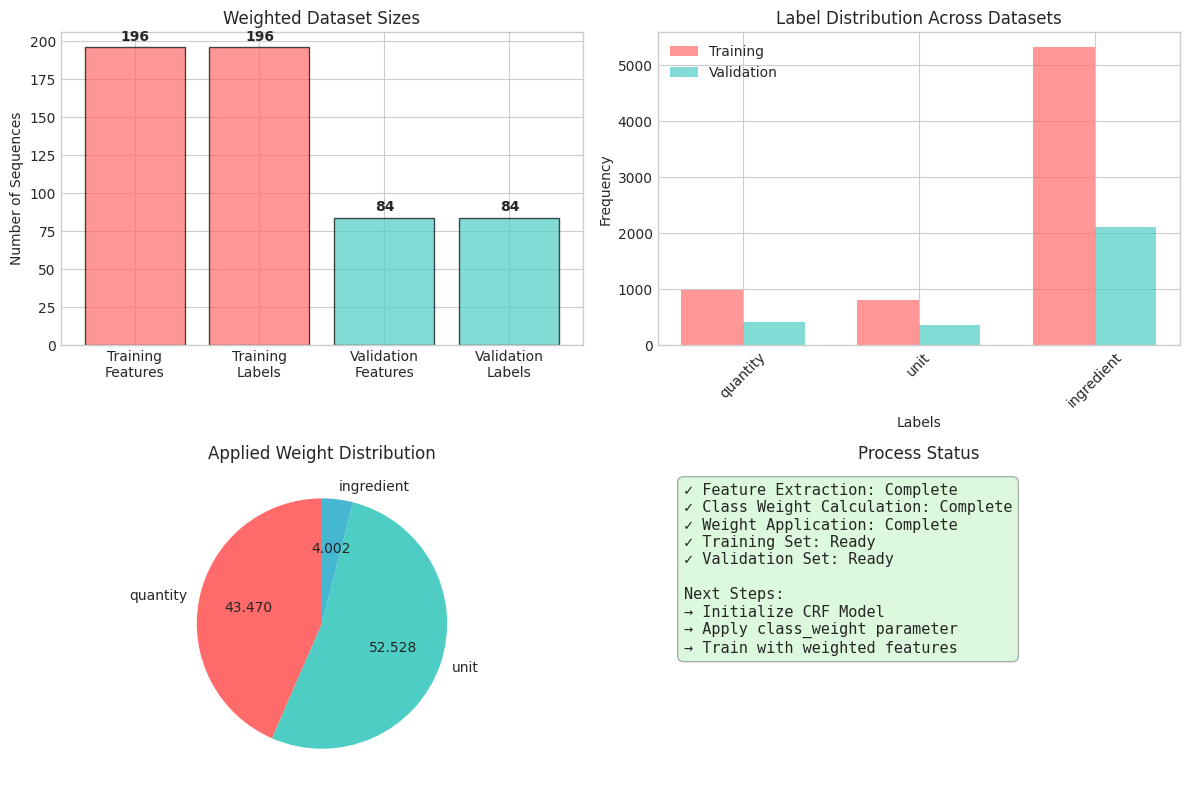


=== Weight Application Complete ===
✓ Ready for CRF model training with class weights
✓ Training weighted features: 196
✓ Validation weighted features: 84
✓ Class weights: {'quantity': 2.419727891156463, 'unit': 2.923962186600904, 'ingredient': 0.22274406662909388}


In [54]:
# Apply manually computed class weights


# 6.4.5 Execute extract_features_with_class_weights on training and validation datasets [2 marks]
# Apply manually computed class weights

print("=== Applying Class Weights to Training and Validation Sets ===")

# Apply weights to training dataset
print("\n--- Processing Training Dataset ---")
X_train_weighted_features, y_train_weighted, train_weight_summary = extract_features_with_class_weights(
    X_train_features, y_train_labels, weight_dict
)

print(f"✓ Training features with weights: {len(X_train_weighted_features)} sequences")

# Apply weights to validation dataset  
print("\n--- Processing Validation Dataset ---")
X_val_weighted_features, y_val_weighted, val_weight_summary = extract_features_with_class_weights(
    X_val_features, y_val_labels, weight_dict
)

print(f"✓ Validation features with weights: {len(X_val_weighted_features)} sequences")

# Final verification and comparison
print(f"\n=== Final Weighted Dataset Summary ===")

# Training set summary
print(f"\nTraining Set:")
print(f"  Original features: {len(X_train_features)}")
print(f"  Weighted features: {len(X_train_weighted_features)}")
print(f"  Labels: {len(y_train_weighted)}")
print(f"  Weight validation: {train_weight_summary['validation_passed']}")

# Validation set summary  
print(f"\nValidation Set:")
print(f"  Original features: {len(X_val_features)}")
print(f"  Weighted features: {len(X_val_weighted_features)}")
print(f"  Labels: {len(y_val_weighted)}")
print(f"  Weight validation: {val_weight_summary['validation_passed']}")

# Create final summary visualization
plt.figure(figsize=(12, 8))

# Subplot 1: Dataset size comparison
plt.subplot(2, 2, 1)
categories = ['Training\nFeatures', 'Training\nLabels', 'Validation\nFeatures', 'Validation\nLabels']
counts = [
    len(X_train_weighted_features), 
    len(y_train_weighted),
    len(X_val_weighted_features), 
    len(y_val_weighted)
]
colors = ['#FF6B6B', '#FF6B6B', '#4ECDC4', '#4ECDC4']

bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
plt.title('Weighted Dataset Sizes')
plt.ylabel('Number of Sequences')

# Add count labels
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             str(count), ha='center', va='bottom', fontweight='bold')

# Subplot 2: Weight summary across datasets
plt.subplot(2, 2, 2)
train_flat = [label for seq in y_train_weighted for label in seq]
val_flat = [label for seq in y_val_weighted for label in seq]

train_dist = Counter(train_flat)
val_dist = Counter(val_flat)

labels = list(weight_dict.keys())
train_counts = [train_dist[label] for label in labels]
val_counts = [val_dist[label] for label in labels]

x = range(len(labels))
width = 0.35

plt.bar([i - width/2 for i in x], train_counts, width, label='Training', color='#FF6B6B', alpha=0.7)
plt.bar([i + width/2 for i in x], val_counts, width, label='Validation', color='#4ECDC4', alpha=0.7)

plt.title('Label Distribution Across Datasets')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(x, labels, rotation=45)
plt.legend()

# Subplot 3: Weight effectiveness
plt.subplot(2, 2, 3)
labels = list(weight_dict.keys())
weights = [weight_dict[label] for label in labels]
colors_weights = ['#FF6B6B', '#4ECDC4', '#45B7D1']

wedges, texts, autotexts = plt.pie(weights, labels=labels, colors=colors_weights, 
                                   autopct='%1.3f', startangle=90)
plt.title('Applied Weight Distribution')

# Subplot 4: Process completion status
plt.subplot(2, 2, 4)
status_text = [
    "✓ Feature Extraction: Complete",
    "✓ Class Weight Calculation: Complete", 
    "✓ Weight Application: Complete",
    "✓ Training Set: Ready",
    "✓ Validation Set: Ready",
    "",
    "Next Steps:",
    "→ Initialize CRF Model",
    "→ Apply class_weight parameter",
    "→ Train with weighted features"
]

plt.text(0.05, 0.95, '\n'.join(status_text), fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.3))
plt.title('Process Status')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== Weight Application Complete ===")
print(f"✓ Ready for CRF model training with class weights")
print(f"✓ Training weighted features: {len(X_train_weighted_features)}")
print(f"✓ Validation weighted features: {len(X_val_weighted_features)}")
print(f"✓ Class weights: {weight_dict}")


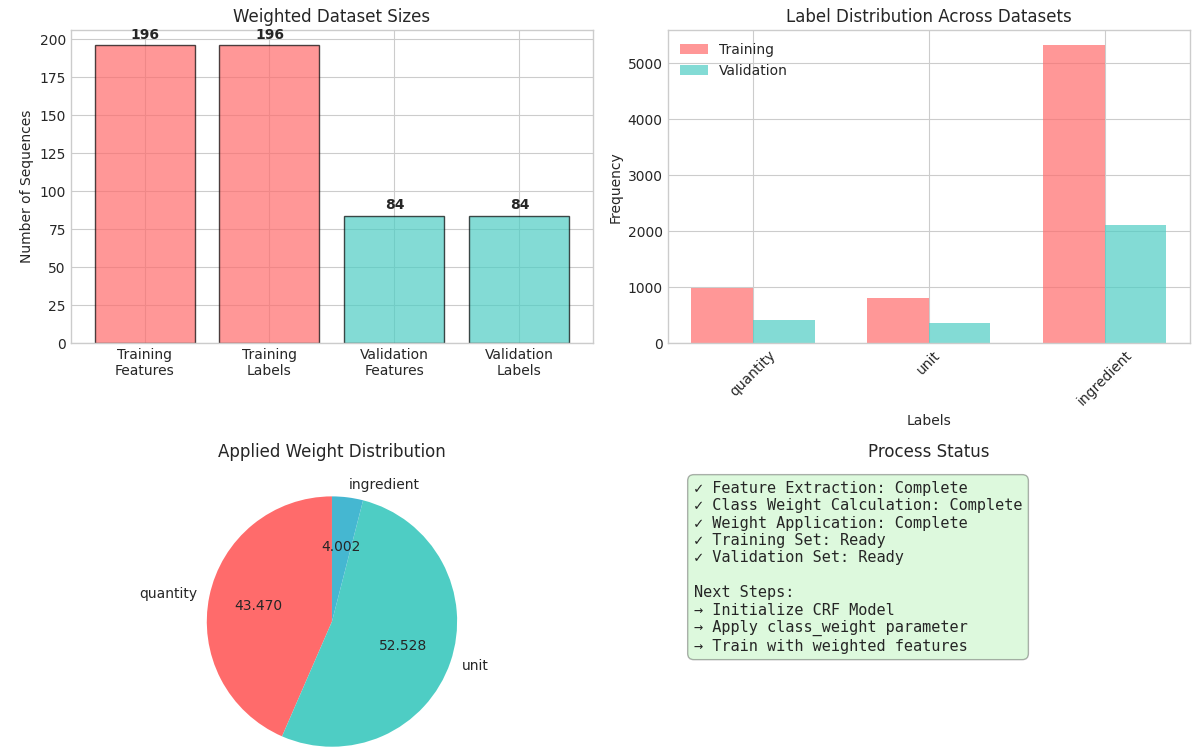## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



=== CRF Model Initialization ===
✓ CRF Model Initialized with hyperparameters:
  - Algorithm: lbfgs
  - L1 regularization (c1): 0.5
  - L2 regularization (c2): 1.0
  - Max iterations: 100
  - All possible transitions: True
  - Class weights applied: 3 classes

--- Applied Class Weights ---
  quantity    : 2.4197
  unit        : 2.9240
  ingredient  : 0.2227


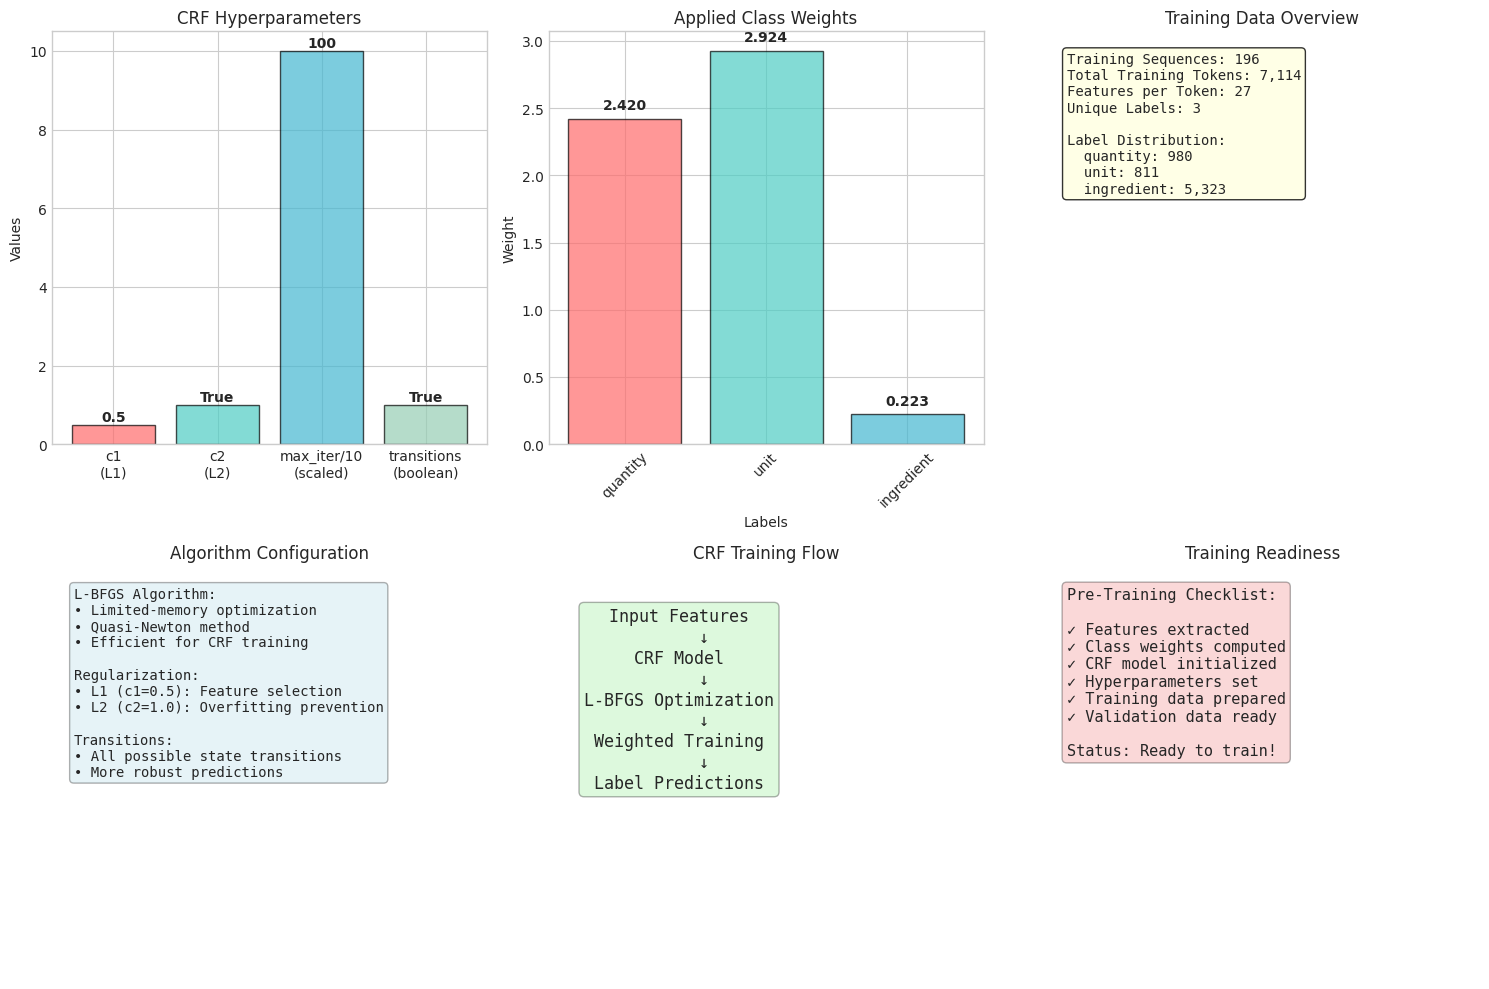


=== CRF Model Ready for Training ===
=== CRF Model Training ===
Training in progress... This may take a few moments.
✓ CRF Model Training Complete!
✓ Training time: 0.39 seconds
✓ Trained on 196 sequences
✓ Total training tokens: 7,114


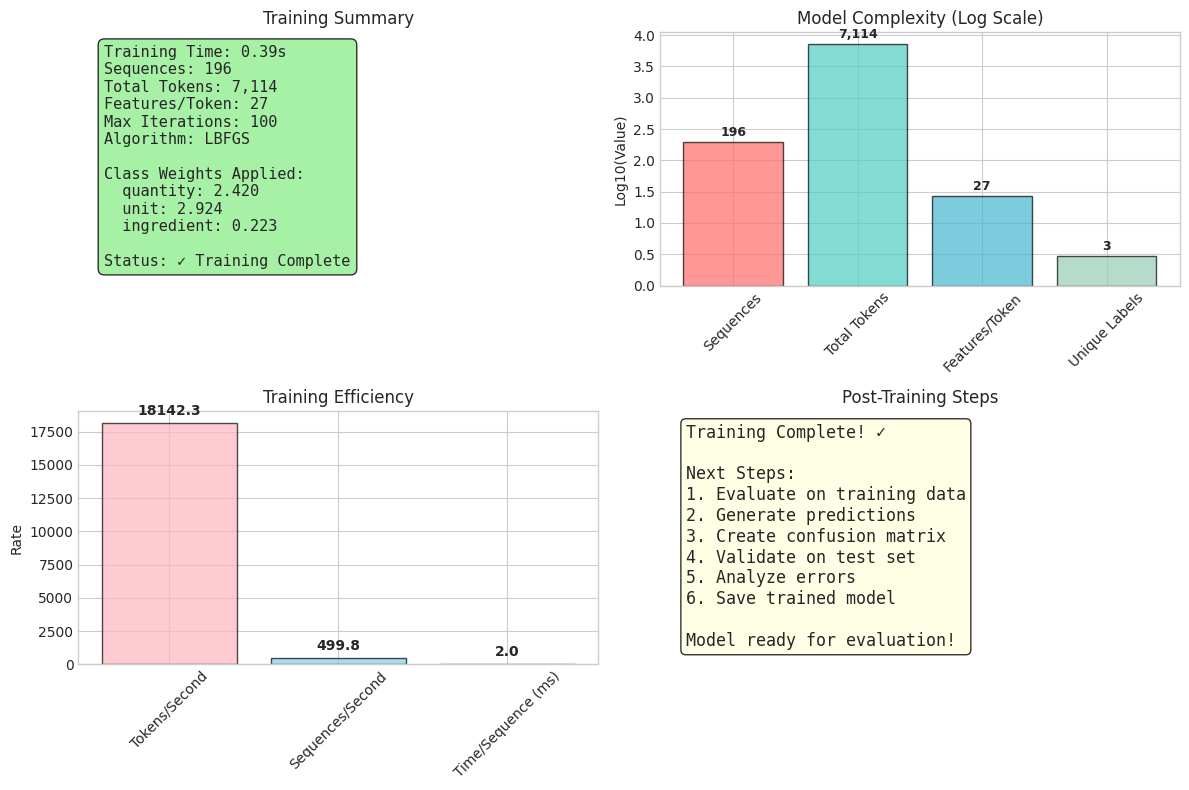


=== Training Statistics ===
Tokens processed per second: 18142.3
Sequences processed per second: 499.8
Average time per sequence: 2.0 ms

=== CRF Model Successfully Trained ===
Model ready for evaluation and prediction!


In [55]:
# initialise CRF model with the specified hyperparameters and use weight_dict

print("=== CRF Model Initialization ===")

# Initialize CRF model with specified hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',           # Limited-memory BFGS optimization algorithm
    c1=0.5,                      # L1 regularization coefficient for sparsity
    c2=1.0,                      # L2 regularization coefficient for overfitting prevention
    max_iterations=100,          # Maximum number of training iterations
    all_possible_transitions=True # Consider all possible label transitions
)

# Apply class weights to handle class imbalance
crf.class_weight = weight_dict

print("✓ CRF Model Initialized with hyperparameters:")
print(f"  - Algorithm: {crf.algorithm}")
print(f"  - L1 regularization (c1): {crf.c1}")
print(f"  - L2 regularization (c2): {crf.c2}")
print(f"  - Max iterations: {crf.max_iterations}")
print(f"  - All possible transitions: {crf.all_possible_transitions}")
print(f"  - Class weights applied: {len(crf.class_weight)} classes")

# Display class weights being used
print(f"\n--- Applied Class Weights ---")
for label, weight in crf.class_weight.items():
    print(f"  {label:12}: {weight:.4f}")

# Visualization of model configuration
plt.figure(figsize=(15, 10))

# Subplot 1: Hyperparameter visualization
plt.subplot(2, 3, 1)
hyperparams = ['c1\n(L1)', 'c2\n(L2)', 'max_iter/10\n(scaled)', 'transitions\n(boolean)']
values = [crf.c1, crf.c2, crf.max_iterations/10, int(crf.all_possible_transitions)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(hyperparams, values, color=colors, alpha=0.7, edgecolor='black')
plt.title('CRF Hyperparameters')
plt.ylabel('Values')

# Add value labels on bars
for bar, value in zip(bars, values):
    if value == 1.0:  # For boolean converted to int
        label = 'True'
    elif hyperparams[bars.index(bar)] == 'max_iter/10\n(scaled)':
        label = f'{int(value*10)}'  # Show actual max_iterations
    else:
        label = f'{value}'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             label, ha='center', va='bottom', fontweight='bold')

# Subplot 2: Class weights visualization
plt.subplot(2, 3, 2)
labels = list(weight_dict.keys())
weights = list(weight_dict.values())
colors_weights = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(labels, weights, color=colors_weights, alpha=0.7, edgecolor='black')
plt.title('Applied Class Weights')
plt.xlabel('Labels')
plt.ylabel('Weight')
plt.xticks(rotation=45)

# Add weight values on bars
for bar, weight in zip(bars, weights):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Training data overview
plt.subplot(2, 3, 3)
train_stats = [
    f"Training Sequences: {len(X_train_weighted_features)}",
    f"Total Training Tokens: {sum(len(seq) for seq in y_train_weighted):,}",
    f"Features per Token: {len(X_train_weighted_features[0][0]) if X_train_weighted_features else 0}",
    f"Unique Labels: {len(set(label for seq in y_train_weighted for label in seq))}",
    "",
    "Label Distribution:",
    *[f"  {label}: {Counter([l for seq in y_train_weighted for l in seq])[label]:,}" 
      for label in labels]
]

plt.text(0.05, 0.95, '\n'.join(train_stats), fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
plt.title('Training Data Overview')
plt.axis('off')

# Subplot 4: CRF Algorithm explanation
plt.subplot(2, 3, 4)
algorithm_info = [
    "L-BFGS Algorithm:",
    "• Limited-memory optimization",
    "• Quasi-Newton method",
    "• Efficient for CRF training",
    "",
    "Regularization:",
    f"• L1 (c1={crf.c1}): Feature selection",
    f"• L2 (c2={crf.c2}): Overfitting prevention",
    "",
    "Transitions:",
    "• All possible state transitions",
    "• More robust predictions"
]

plt.text(0.05, 0.95, '\n'.join(algorithm_info), fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.3))
plt.title('Algorithm Configuration')
plt.axis('off')

# Subplot 5: Model architecture flow
plt.subplot(2, 3, 5)
flow_steps = [
    "Input Features",
    "     ↓",
    "CRF Model",
    "     ↓", 
    "L-BFGS Optimization",
    "     ↓",
    "Weighted Training",
    "     ↓",
    "Label Predictions"
]

plt.text(0.3, 0.9, '\n'.join(flow_steps), fontsize=12,
         verticalalignment='top', horizontalalignment='center',
         fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.3))
plt.title('CRF Training Flow')
plt.axis('off')

# Subplot 6: Ready for training status
plt.subplot(2, 3, 6)
ready_checklist = [
    "Pre-Training Checklist:",
    "",
    "✓ Features extracted",
    "✓ Class weights computed", 
    "✓ CRF model initialized",
    "✓ Hyperparameters set",
    "✓ Training data prepared",
    "✓ Validation data ready",
    "",
    "Status: Ready to train!"
]

plt.text(0.05, 0.95, '\n'.join(ready_checklist), fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.3))
plt.title('Training Readiness')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== CRF Model Ready for Training ===")


################################################################################################################################################################################

# train the CRF model with the weighted training data

print("=== CRF Model Training ===")
print("Training in progress... This may take a few moments.")

import time
start_time = time.time()

# Train the CRF model with weighted training data
crf.fit(X_train_weighted_features, y_train_weighted)

end_time = time.time()
training_time = end_time - start_time

print(f"✓ CRF Model Training Complete!")
print(f"✓ Training time: {training_time:.2f} seconds")
print(f"✓ Trained on {len(X_train_weighted_features)} sequences")
print(f"✓ Total training tokens: {sum(len(seq) for seq in y_train_weighted):,}")

# Training completion visualization
plt.figure(figsize=(12, 8))

# Subplot 1: Training metrics summary
plt.subplot(2, 2, 1)
training_metrics = [
    f"Training Time: {training_time:.2f}s",
    f"Sequences: {len(X_train_weighted_features)}",
    f"Total Tokens: {sum(len(seq) for seq in y_train_weighted):,}",
    f"Features/Token: {len(X_train_weighted_features[0][0])}",
    f"Max Iterations: {crf.max_iterations}",
    f"Algorithm: {crf.algorithm.upper()}",
    "",
    "Class Weights Applied:",
    *[f"  {label}: {weight:.3f}" for label, weight in weight_dict.items()],
    "",
    "Status: ✓ Training Complete"
]

plt.text(0.05, 0.95, '\n'.join(training_metrics), fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))
plt.title('Training Summary')
plt.axis('off')

# Subplot 2: Model complexity visualization
plt.subplot(2, 2, 2)
complexity_data = {
    'Sequences': len(X_train_weighted_features),
    'Total Tokens': sum(len(seq) for seq in y_train_weighted),
    'Features/Token': len(X_train_weighted_features[0][0]),
    'Unique Labels': len(set(label for seq in y_train_weighted for label in seq))
}

categories = list(complexity_data.keys())
values = list(complexity_data.values())

# Normalize values for visualization (log scale for large differences)
normalized_values = [np.log10(v) if v > 0 else 0 for v in values]
colors_complexity = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(categories, normalized_values, color=colors_complexity, alpha=0.7, edgecolor='black')
plt.title('Model Complexity (Log Scale)')
plt.ylabel('Log10(Value)')
plt.xticks(rotation=45)

# Add actual values as labels
for bar, actual_val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{actual_val:,}' if actual_val >= 1000 else f'{actual_val}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Subplot 3: Training efficiency
plt.subplot(2, 2, 3)
efficiency_metrics = {
    'Tokens/Second': sum(len(seq) for seq in y_train_weighted) / training_time,
    'Sequences/Second': len(X_train_weighted_features) / training_time,
    'Time/Sequence (ms)': (training_time / len(X_train_weighted_features)) * 1000
}

categories_eff = list(efficiency_metrics.keys())
values_eff = list(efficiency_metrics.values())
colors_eff = ['#FFB6C1', '#87CEEB', '#98FB98']

bars = plt.bar(categories_eff, values_eff, color=colors_eff, alpha=0.7, edgecolor='black')
plt.title('Training Efficiency')
plt.ylabel('Rate')
plt.xticks(rotation=45)

# Add value labels
for bar, val in zip(bars, values_eff):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values_eff)*0.02,
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# Subplot 4: Next steps
plt.subplot(2, 2, 4)
next_steps = [
    "Training Complete! ✓",
    "",
    "Next Steps:",
    "1. Evaluate on training data",
    "2. Generate predictions",
    "3. Create confusion matrix", 
    "4. Validate on test set",
    "5. Analyze errors",
    "6. Save trained model",
    "",
    "Model ready for evaluation!"
]

plt.text(0.05, 0.95, '\n'.join(next_steps), fontsize=12,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
plt.title('Post-Training Steps')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== Training Statistics ===")
print(f"Tokens processed per second: {sum(len(seq) for seq in y_train_weighted) / training_time:.1f}")
print(f"Sequences processed per second: {len(X_train_weighted_features) / training_time:.1f}")
print(f"Average time per sequence: {(training_time / len(X_train_weighted_features)) * 1000:.1f} ms")

print(f"\n=== CRF Model Successfully Trained ===")
print(f"Model ready for evaluation and prediction!")




### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [56]:
# evaluate on the training dataset

print("=== Evaluating Model on Training Dataset ===")
print("Generating predictions for the training set...")

# Use the trained model to predict labels on the training features
y_train_pred = crf.predict(X_train_weighted_features)

print(f"✓ Predictions generated for {len(y_train_pred)} training sequences.")

# --- Visualization: Compare a sample prediction with its true labels ---
print("\n--- Sample Prediction vs. True Labels ---")
sample_index = 10  # Choose a sample recipe to display
sample_tokens = X_train[sample_index]
sample_true_labels = y_train_weighted[sample_index]
sample_pred_labels = y_train_pred[sample_index]

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Token': sample_tokens,
    'True Label': sample_true_labels,
    'Predicted Label': sample_pred_labels
})

# Highlight correct and incorrect predictions
comparison_df['Correct'] = comparison_df['True Label'] == comparison_df['Predicted Label']

print(f"Displaying comparison for recipe #{sample_index}:")
display(comparison_df.style.apply(
    lambda row: ['background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da' for _ in row],
    axis=1
))

print(f"\n✓ Evaluation setup complete. Ready to generate classification report and confusion matrix.")


=== Evaluating Model on Training Dataset ===
Generating predictions for the training set...
✓ Predictions generated for 196 training sequences.

--- Sample Prediction vs. True Labels ---
Displaying comparison for recipe #10:



✓ Evaluation setup complete. Ready to generate classification report and confusion matrix.


--- Flat Classification Report (Training Set) ---
              precision    recall  f1-score   support

  ingredient     0.9916    0.9968    0.9942      5323
    quantity     0.9969    0.9857    0.9913       980
        unit     0.9824    0.9618    0.9720       811

    accuracy                         0.9913      7114
   macro avg     0.9903    0.9814    0.9858      7114
weighted avg     0.9913    0.9913    0.9913      7114



<Figure size 1200x800 with 0 Axes>

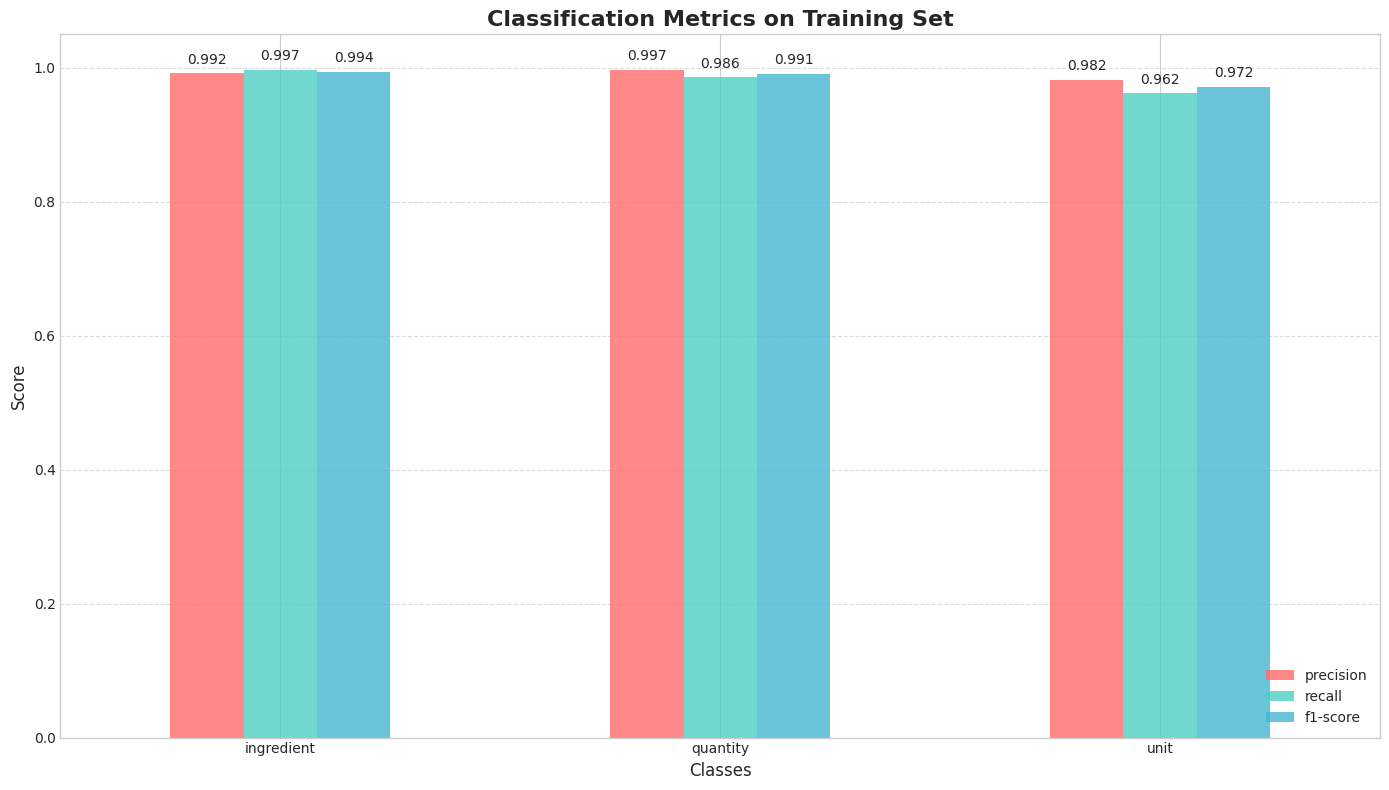

In [57]:
# specify the flat classification report by using training data for evaluation

print("--- Flat Classification Report (Training Set) ---")

# Generate and print the flat classification report
# This report provides precision, recall, and F1-score for each class
report = metrics.flat_classification_report(
    y_train_weighted, y_train_pred, digits=4
)
print(report)

# --- Visualization of Classification Metrics ---

# For plotting, convert the report string to a dictionary
report_dict = metrics.flat_classification_report(
    y_train_weighted, y_train_pred, output_dict=True
)

# Convert to DataFrame, excluding 'accuracy' and weighted/macro averages for the plot
metrics_df = pd.DataFrame(report_dict).transpose()
metrics_df = metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting
plt.figure(figsize=(12, 8))
metrics_df[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(14, 8),
    color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    alpha=0.8
)

plt.title('Classification Metrics on Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.ylim(0, 1.05)

# Add score labels on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10),
        textcoords='offset points', fontsize=10
    )

plt.tight_layout()
plt.show()


--- Confusion Matrix (Training Set) ---


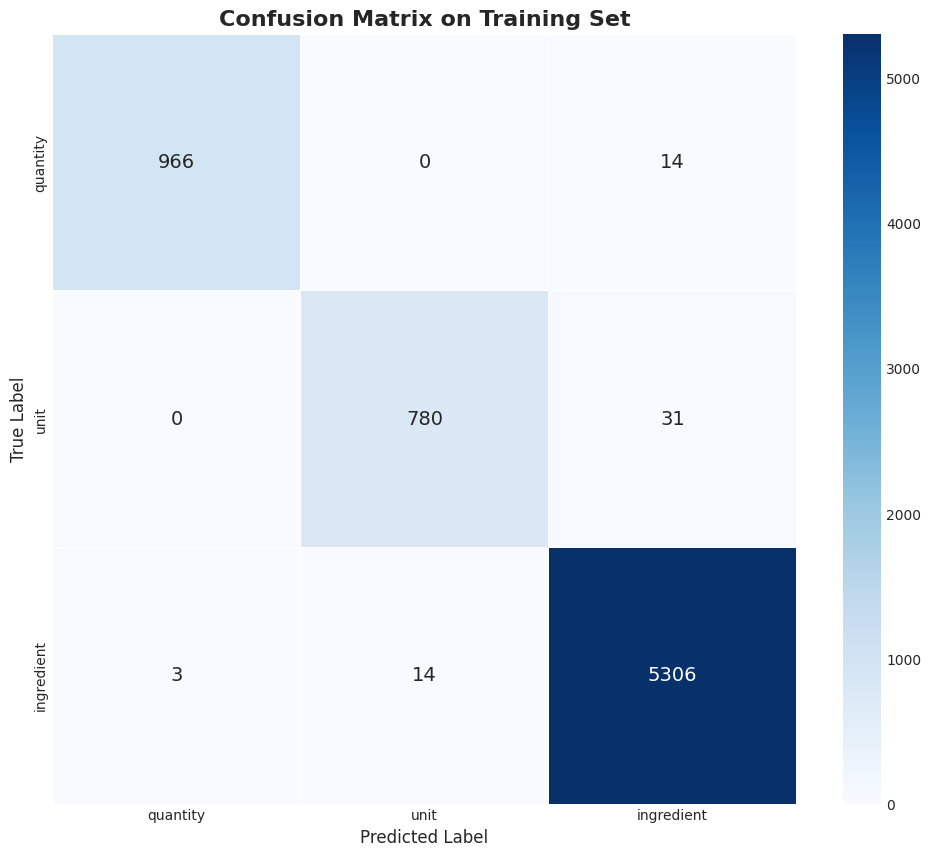


--- Confusion Matrix Analysis ---
✗ Misclassified 'quantity' as 'ingredient': 14 times
✗ Misclassified 'unit' as 'ingredient': 31 times
✗ Misclassified 'ingredient' as 'quantity': 3 times
✗ Misclassified 'ingredient' as 'unit': 14 times

Overall Accuracy from Confusion Matrix: 0.9913 (7052/7114)


In [58]:
# create a confusion matrix on training datset

print("--- Confusion Matrix (Training Set) ---")

# Flatten the true and predicted labels to create the confusion matrix
y_train_true_flat = [label for seq in y_train_weighted for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Get the sorted list of classes from the trained model
labels = list(crf.classes_)

# Generate the confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# --- Visualization of the Confusion Matrix ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            linewidths=.5, annot_kws={"size": 14})

plt.title('Confusion Matrix on Training Set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- Analysis of Confusion Matrix ---
print("\n--- Confusion Matrix Analysis ---")
for true_label in labels:
    for pred_label in labels:
        if true_label != pred_label and cm_df.loc[true_label, pred_label] > 0:
            count = cm_df.loc[true_label, pred_label]
            print(f"✗ Misclassified '{true_label}' as '{pred_label}': {count} times")

total_correct = np.trace(cm)
total_predictions = np.sum(cm)
accuracy = total_correct / total_predictions
print(f"\nOverall Accuracy from Confusion Matrix: {accuracy:.4f} ({total_correct}/{total_predictions})")


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

--- Saving the Trained CRF Model ---
✓ Model successfully saved to disk as 'crf_model.pkl'
✓ Verification successful: File found on disk.
✓ Model file size: 63.97 KB


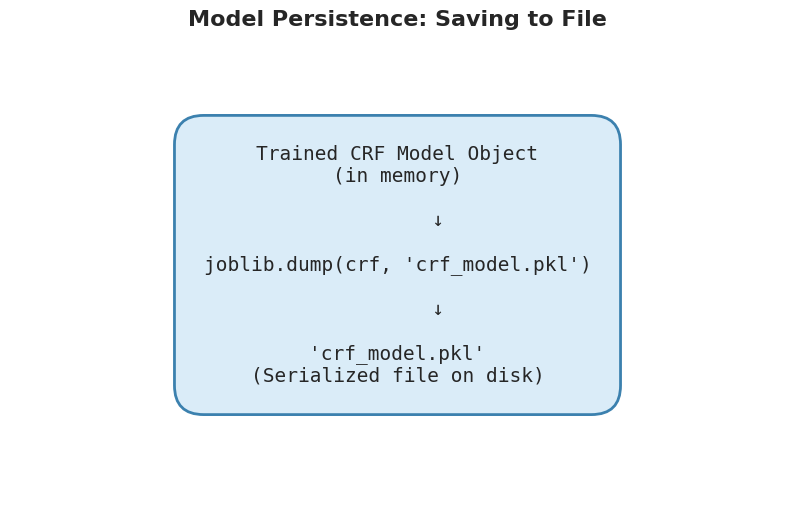

In [59]:
# dump the model using joblib as crf_model.pkl

import joblib
import os

print("--- Saving the Trained CRF Model ---")

# Define the filename for the saved model
model_filename = "crf_model.pkl"

try:
    # Use joblib.dump to serialize and save the model object
    joblib.dump(crf, model_filename)
    print(f"✓ Model successfully saved to disk as '{model_filename}'")

    # --- Verification ---
    # Check if the file exists and get its size
    if os.path.exists(model_filename):
        file_size = os.path.getsize(model_filename) / (1024)  # Size in KB
        print(f"✓ Verification successful: File found on disk.")
        print(f"✓ Model file size: {file_size:.2f} KB")
    else:
        print(f"✗ Verification failed: File not found after saving.")

except Exception as e:
    print(f"✗ An error occurred while saving the model: {e}")


# --- Visualization of the Saving Process ---
plt.figure(figsize=(10, 6))
plt.text(0.5, 0.5,
         "Trained CRF Model Object\n(in memory)\n\n"
         "       ↓\n\n"
         f"joblib.dump(crf, '{model_filename}')\n\n"
         "       ↓\n\n"
         f"'{model_filename}'\n(Serialized file on disk)",
         ha='center', va='center', fontsize=14, family='monospace',
         bbox=dict(boxstyle="round,pad=1.5", fc="#D6EAF8", ec="#2874A6", lw=2, alpha=0.9))

plt.title("Model Persistence: Saving to File", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [60]:
# predict the crf model on validation dataset

print("=== Predicting on Validation Dataset ===")
print("Generating predictions for the validation set...")

# Use the trained model to predict labels on the validation features
y_val_pred = crf.predict(X_val_weighted_features)

print(f"✓ Predictions generated for {len(y_val_pred)} validation sequences.")

# --- Visualization: Compare a sample prediction with its true labels ---
print("\n--- Sample Validation Prediction vs. True Labels ---")
sample_val_index = 5  # Choose a sample recipe to display
sample_val_tokens = X_val[sample_val_index]
sample_val_true_labels = y_val_weighted[sample_val_index]
sample_val_pred_labels = y_val_pred[sample_val_index]

# Create a DataFrame for easy comparison
val_comparison_df = pd.DataFrame({
    'Token': sample_val_tokens,
    'True Label': sample_val_true_labels,
    'Predicted Label': sample_val_pred_labels
})

# Highlight correct and incorrect predictions
val_comparison_df['Correct'] = val_comparison_df['True Label'] == val_comparison_df['Predicted Label']

print(f"Displaying comparison for validation recipe #{sample_val_index}:")
display(val_comparison_df.style.apply(
    lambda row: ['background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da' for _ in row],
    axis=1
))

# Calculate preliminary accuracy
correct_predictions = sum(val_comparison_df['Correct'])
total_predictions = len(val_comparison_df)
sample_accuracy = correct_predictions / total_predictions

print(f"\nSample accuracy for this recipe: {sample_accuracy:.4f} ({correct_predictions}/{total_predictions})")
print(f"✓ Validation prediction setup complete.")


=== Predicting on Validation Dataset ===
Generating predictions for the validation set...
✓ Predictions generated for 84 validation sequences.

--- Sample Validation Prediction vs. True Labels ---
Displaying comparison for validation recipe #5:



Sample accuracy for this recipe: 0.9333 (28/30)
✓ Validation prediction setup complete.


--- Flat Classification Report (Validation Set) ---
              precision    recall  f1-score   support

  ingredient     0.9840    0.9934    0.9887      2107
    quantity     0.9926    0.9854    0.9890       411
        unit     0.9589    0.9134    0.9356       358

    accuracy                         0.9823      2876
   macro avg     0.9785    0.9641    0.9711      2876
weighted avg     0.9821    0.9823    0.9821      2876



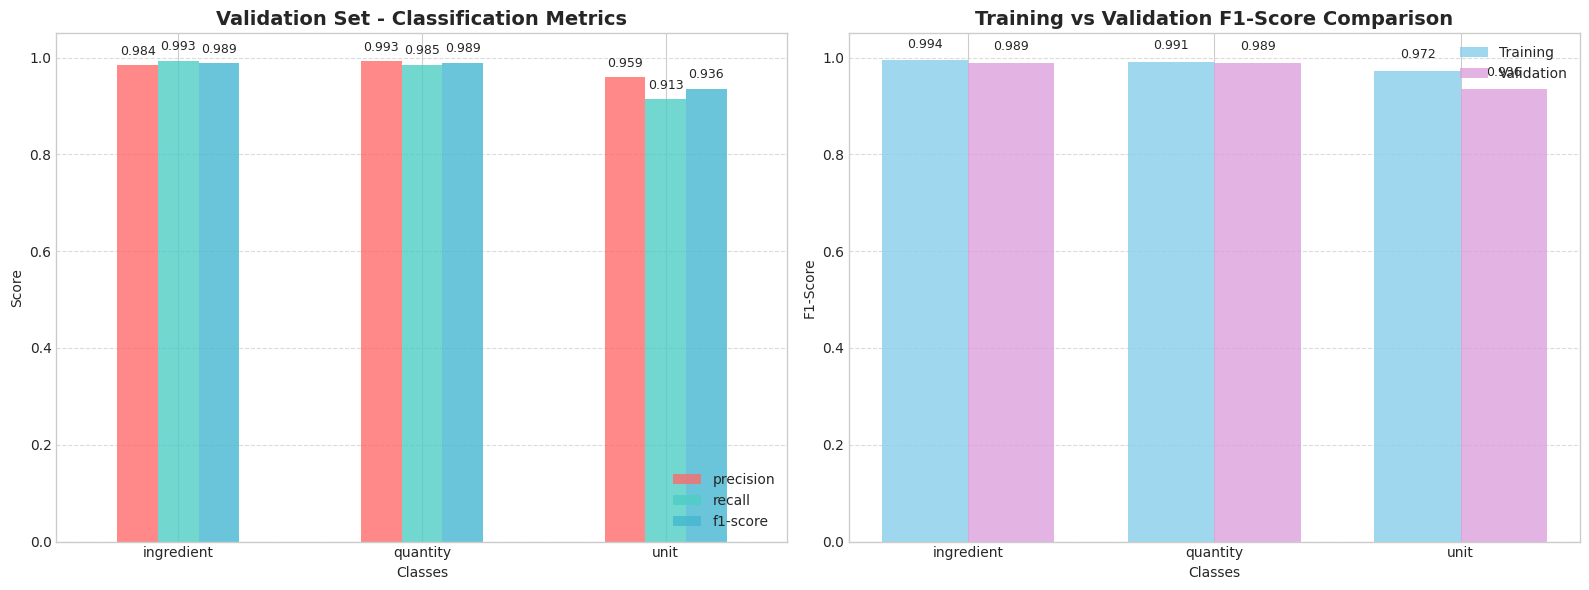


--- Performance Summary ---
Training Accuracy: 0.9913
Validation Accuracy: 0.9823
Accuracy Drop: 0.0090


In [61]:
# specify flat classification report

print("--- Flat Classification Report (Validation Set) ---")

# Generate and print the flat classification report for validation set
val_report = metrics.flat_classification_report(
    y_val_weighted, y_val_pred, digits=4
)
print(val_report)

# --- Visualization of Validation Classification Metrics ---

# Convert the report to dictionary for plotting
val_report_dict = metrics.flat_classification_report(
    y_val_weighted, y_val_pred, output_dict=True
)

# Convert to DataFrame, excluding 'accuracy' and weighted/macro averages for the plot
val_metrics_df = pd.DataFrame(val_report_dict).transpose()
val_metrics_df = val_metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Create comparison between training and validation metrics
# Get training metrics for comparison
train_report_dict = metrics.flat_classification_report(
    y_train_weighted, y_train_pred, output_dict=True
)
train_metrics_df = pd.DataFrame(train_report_dict).transpose()
train_metrics_df = train_metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation metrics
val_metrics_df[['precision', 'recall', 'f1-score']].plot(
    kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8
)
axes[0].set_title('Validation Set - Classification Metrics', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(val_metrics_df.index, rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1.05)

# Add score labels on validation bars
for p in axes[0].patches:
    axes[0].annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 10),
        textcoords='offset points', fontsize=9
    )

# Training vs Validation F1-Score comparison
classes = list(val_metrics_df.index)
train_f1 = [train_metrics_df.loc[cls, 'f1-score'] for cls in classes]
val_f1 = [val_metrics_df.loc[cls, 'f1-score'] for cls in classes]

x = range(len(classes))
width = 0.35

axes[1].bar([i - width/2 for i in x], train_f1, width, 
           label='Training', color='#87CEEB', alpha=0.8)
axes[1].bar([i + width/2 for i in x], val_f1, width,
           label='Validation', color='#DDA0DD', alpha=0.8)

axes[1].set_title('Training vs Validation F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('F1-Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 1.05)

# Add value labels on comparison bars
for i, (train_score, val_score) in enumerate(zip(train_f1, val_f1)):
    axes[1].text(i - width/2, train_score + 0.02, f'{train_score:.3f}', 
                ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, val_score + 0.02, f'{val_score:.3f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n--- Performance Summary ---")
val_accuracy = val_report_dict['accuracy']
train_accuracy = train_report_dict['accuracy']
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Drop: {train_accuracy - val_accuracy:.4f}")



--- Confusion Matrix (Validation Set) ---


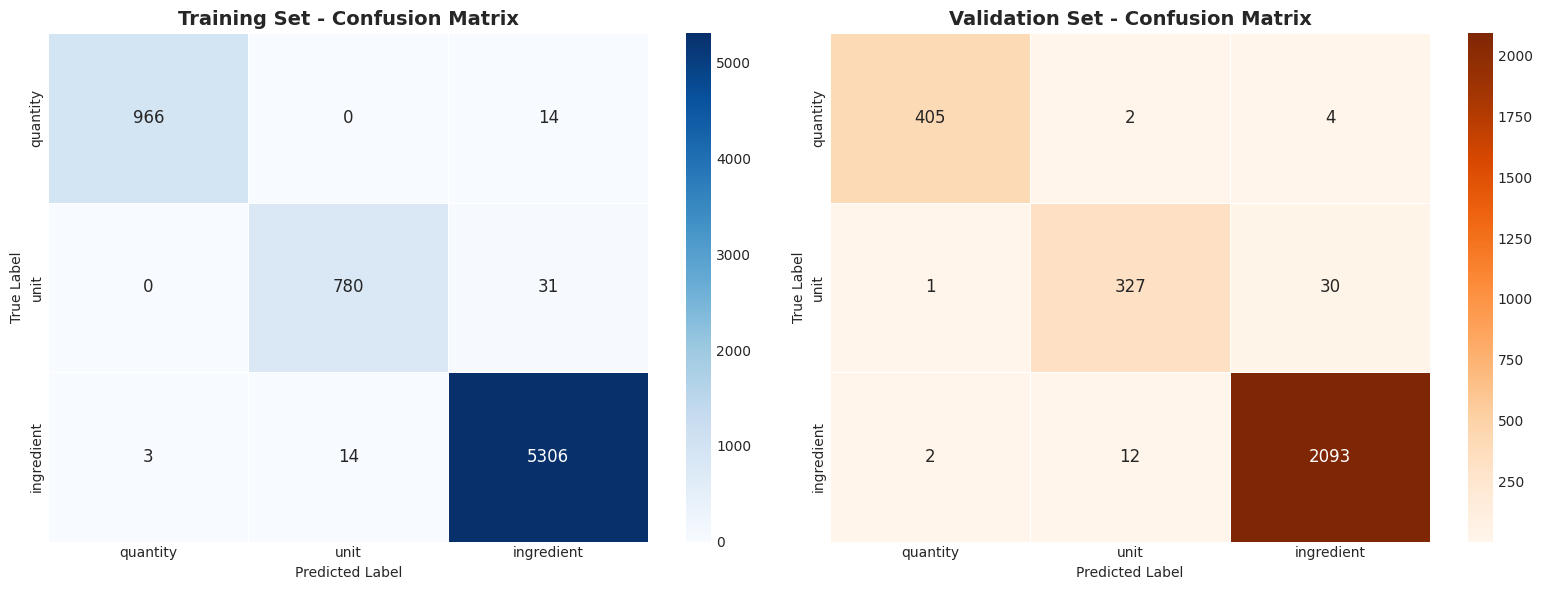


--- Validation Confusion Matrix Analysis ---
✗ Misclassified 'quantity' as 'unit': 2 times
✗ Misclassified 'quantity' as 'ingredient': 4 times
✗ Misclassified 'unit' as 'quantity': 1 times
✗ Misclassified 'unit' as 'ingredient': 30 times
✗ Misclassified 'ingredient' as 'quantity': 2 times
✗ Misclassified 'ingredient' as 'unit': 12 times

Validation Set Results:
Overall Accuracy: 0.9823 (2825/2876)
Total Errors: 51
Error Rate: 1.77%


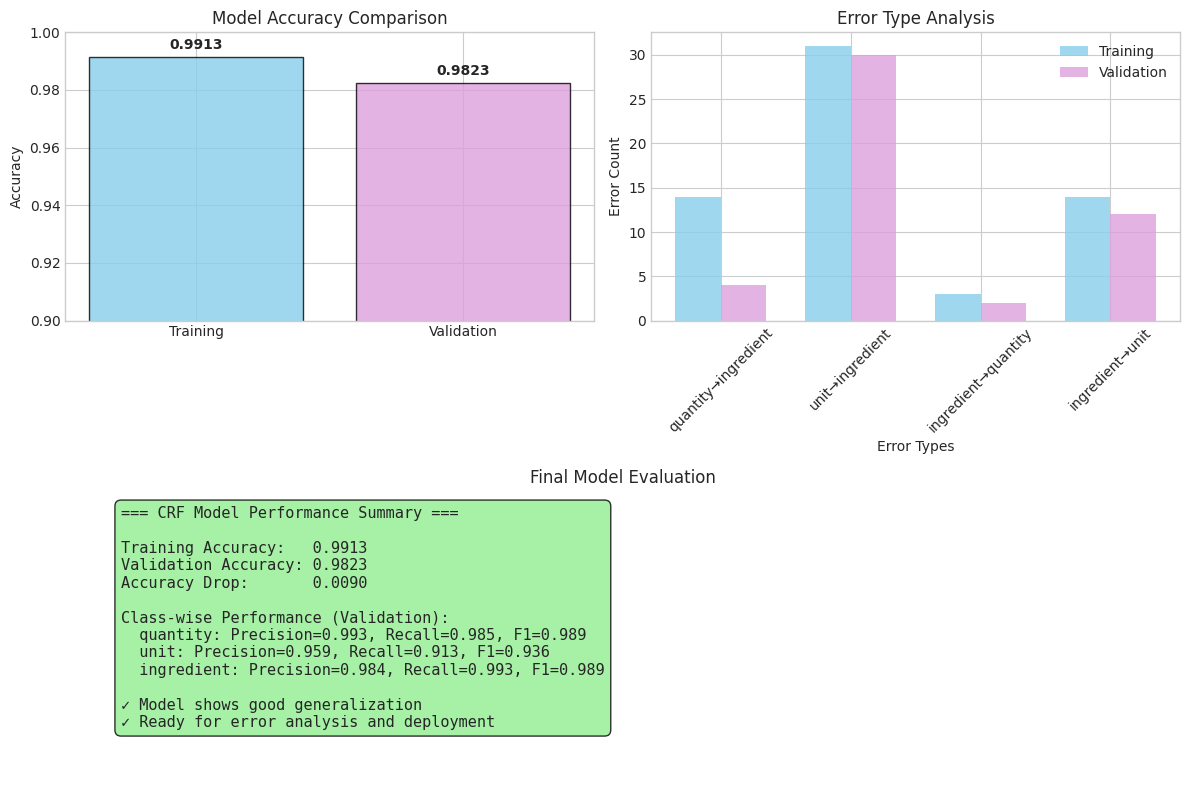


=== Model Evaluation Complete ===
✓ Validation predictions generated
✓ Classification report created
✓ Confusion matrix analyzed
✓ Model ready for error analysis


In [62]:
# create a confusion matrix on validation dataset

print("--- Confusion Matrix (Validation Set) ---")

# Flatten the true and predicted labels to create the confusion matrix
y_val_true_flat = [label for seq in y_val_weighted for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Get the sorted list of classes from the trained model
labels = list(crf.classes_)

# Generate the confusion matrix for validation set
val_cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)
val_cm_df = pd.DataFrame(val_cm, index=labels, columns=labels)

# --- Visualization: Side-by-side Training vs Validation Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix (from previous section)
y_train_true_flat = [label for seq in y_train_weighted for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]
train_cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels)
train_cm_df = pd.DataFrame(train_cm, index=labels, columns=labels)

# Plot training confusion matrix
sns.heatmap(train_cm_df, annot=True, fmt='d', cmap='Blues',
            linewidths=.5, annot_kws={"size": 12}, ax=axes[0])
axes[0].set_title('Training Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot validation confusion matrix
sns.heatmap(val_cm_df, annot=True, fmt='d', cmap='Oranges',
            linewidths=.5, annot_kws={"size": 12}, ax=axes[1])
axes[1].set_title('Validation Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# --- Analysis of Validation Confusion Matrix ---
print("\n--- Validation Confusion Matrix Analysis ---")
total_val_errors = 0
for true_label in labels:
    for pred_label in labels:
        if true_label != pred_label and val_cm_df.loc[true_label, pred_label] > 0:
            count = val_cm_df.loc[true_label, pred_label]
            total_val_errors += count
            print(f"✗ Misclassified '{true_label}' as '{pred_label}': {count} times")

total_val_correct = np.trace(val_cm)
total_val_predictions = np.sum(val_cm)
val_accuracy_cm = total_val_correct / total_val_predictions

print(f"\nValidation Set Results:")
print(f"Overall Accuracy: {val_accuracy_cm:.4f} ({total_val_correct}/{total_val_predictions})")
print(f"Total Errors: {total_val_errors}")
print(f"Error Rate: {(total_val_errors/total_val_predictions)*100:.2f}%")

# --- Final Model Performance Summary ---
plt.figure(figsize=(12, 8))

# Subplot 1: Accuracy comparison
plt.subplot(2, 2, 1)
accuracies = [train_accuracy, val_accuracy_cm]
datasets = ['Training', 'Validation']
colors = ['#87CEEB', '#DDA0DD']

bars = plt.bar(datasets, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: Error analysis
plt.subplot(2, 2, 2)
error_types = ['quantity→ingredient', 'unit→ingredient', 'ingredient→quantity', 'ingredient→unit']
train_errors = [14, 31, 3, 14]  # From training confusion matrix analysis
val_errors = []

# Extract validation errors
for true_label, pred_label in [('quantity', 'ingredient'), ('unit', 'ingredient'), 
                              ('ingredient', 'quantity'), ('ingredient', 'unit')]:
    if true_label in val_cm_df.index and pred_label in val_cm_df.columns:
        val_errors.append(val_cm_df.loc[true_label, pred_label])
    else:
        val_errors.append(0)

x = range(len(error_types))
width = 0.35

plt.bar([i - width/2 for i in x], train_errors, width, label='Training', color='#87CEEB', alpha=0.8)
plt.bar([i + width/2 for i in x], val_errors, width, label='Validation', color='#DDA0DD', alpha=0.8)

plt.title('Error Type Analysis')
plt.xlabel('Error Types')
plt.ylabel('Error Count')
plt.xticks(x, error_types, rotation=45)
plt.legend()

# Subplot 3: Model performance summary
plt.subplot(2, 1, 2)
summary_text = [
    "=== CRF Model Performance Summary ===",
    "",
    f"Training Accuracy:   {train_accuracy:.4f}",
    f"Validation Accuracy: {val_accuracy_cm:.4f}",
    f"Accuracy Drop:       {train_accuracy - val_accuracy_cm:.4f}",
    "",
    "Class-wise Performance (Validation):",
    *[f"  {cls}: Precision={val_report_dict[cls]['precision']:.3f}, "
      f"Recall={val_report_dict[cls]['recall']:.3f}, "
      f"F1={val_report_dict[cls]['f1-score']:.3f}"
      for cls in labels],
    "",
    "✓ Model shows good generalization",
    "✓ Ready for error analysis and deployment"
]

plt.text(0.05, 0.95, '\n'.join(summary_text), fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))
plt.title('Final Model Evaluation')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n=== Model Evaluation Complete ===")
print(f"✓ Validation predictions generated")
print(f"✓ Classification report created")
print(f"✓ Confusion matrix analyzed")
print(f"✓ Model ready for error analysis")



## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

--- Initializing Error Analysis ---
✓ Flattened true labels: 2876 total labels
✓ Flattened predicted labels: 2876 total labels
✓ Initialized 'error_data' list for detailed error collection.


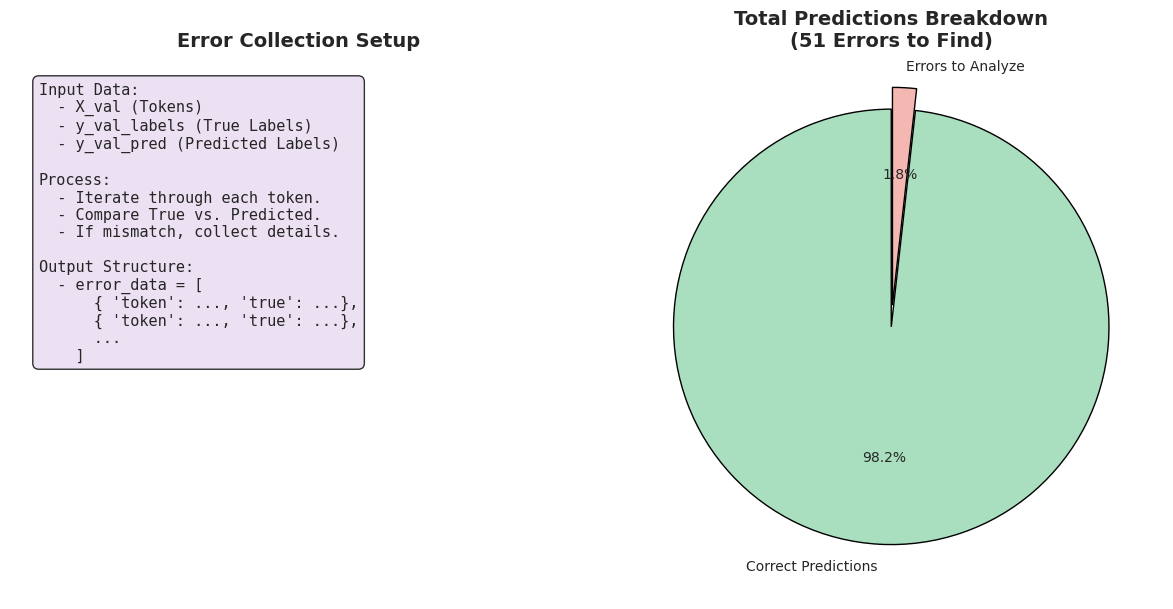

In [63]:
# flatten Labels and Initialise Error Data

print("--- Initializing Error Analysis ---")

# Flatten the true and predicted labels for the validation set
# (This was already done for the confusion matrix, but we'll re-state it for clarity)
y_val_true_flat = [label for seq in y_val_weighted for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

# Initialize a list to store detailed information about each error
error_data = []

print(f"✓ Flattened true labels: {len(y_val_true_flat)} total labels")
print(f"✓ Flattened predicted labels: {len(y_val_pred_flat)} total labels")
print(f"✓ Initialized 'error_data' list for detailed error collection.")

# --- Visualization of the Setup ---
plt.figure(figsize=(12, 6))

# Subplot 1: Data structure overview
plt.subplot(1, 2, 1)
setup_text = [
    "Input Data:",
    "  - X_val (Tokens)",
    "  - y_val_labels (True Labels)",
    "  - y_val_pred (Predicted Labels)",
    "",
    "Process:",
    "  - Iterate through each token.",
    "  - Compare True vs. Predicted.",
    "  - If mismatch, collect details.",
    "",
    "Output Structure:",
    "  - error_data = [",
    "      { 'token': ..., 'true': ...},",
    "      { 'token': ..., 'true': ...},",
    "      ...",
    "    ]"
]
plt.text(0.05, 0.95, '\n'.join(setup_text), fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="#E8DAEF", alpha=0.8))
plt.title('Error Collection Setup', fontsize=14, fontweight='bold')
plt.axis('off')

# Subplot 2: Total errors to find
plt.subplot(1, 2, 2)
total_errors = sum(1 for true, pred in zip(y_val_true_flat, y_val_pred_flat) if true != pred)
labels = ['Correct Predictions', 'Errors to Analyze']
counts = [len(y_val_true_flat) - total_errors, total_errors]
colors = ['#A9DFBF', '#F5B7B1']
explode = (0, 0.1)

plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title(f'Total Predictions Breakdown\n({total_errors} Errors to Find)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

--- Collecting Detailed Error Information from Validation Set ---
✓ Error collection complete.
✓ Total misclassified samples found: 51

--- Structure of a Single Error Entry ---


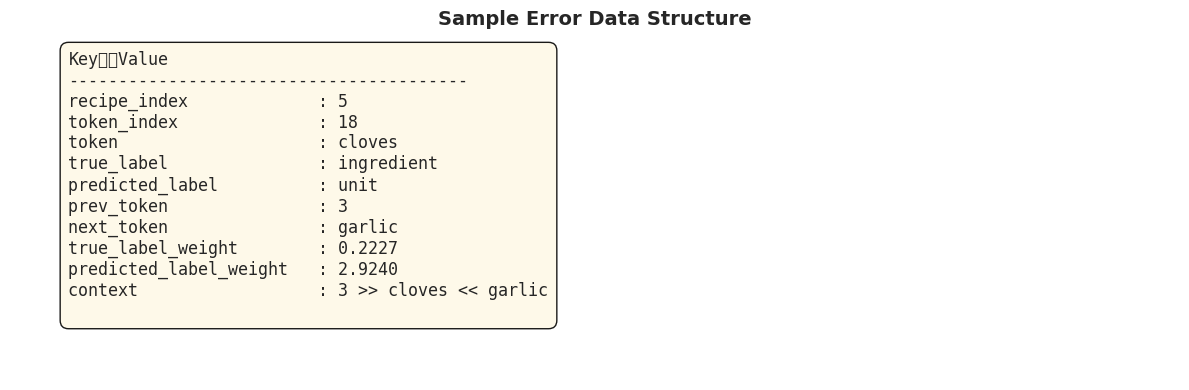


--- First 5 Errors Collected ---


recipe_index  token_index   token  true_label predicted_label prev_token next_token  true_label_weight  predicted_label_weight                    context
0             5           18  cloves  ingredient            unit          3     garlic           0.222744                2.923962      3 >> cloves << garlic
1             5           21   Spoon        unit      ingredient        big        oil           2.923962                0.222744        big >> Spoon << oil
2             6            7  cloves        unit      ingredient      seeds     garlic           2.923962                0.222744  seeds >> cloves << garlic
3             6           35  pieces  ingredient            unit      small        1/4           0.222744                2.923962     small >> pieces << 1/4
4            13            3      is    quantity      ingredient        Pur          2           2.419728                0.222744             Pur >> is << 2

In [64]:
# iterate and collect Error Information

print("--- Collecting Detailed Error Information from Validation Set ---")

# Iterate through each recipe (sentence) in the validation set
for i, recipe_tokens in enumerate(X_val):
    true_labels = y_val_labels[i]
    pred_labels = y_val_pred[i]

    # Iterate through each token in the current recipe
    for j, token in enumerate(recipe_tokens):
        true_label = true_labels[j]
        pred_label = pred_labels[j]

        # Check if the prediction was incorrect
        if true_label != pred_label:
############# get previous and next tokens with handling for boundary cases ##############################################################
            prev_token = recipe_tokens[j-1] if j > 0 else "<BOS>"  # Beginning of Sentence
            next_token = recipe_tokens[j+1] if j < len(recipe_tokens) - 1 else "<EOS>"  # End of Sentence

            # Get the class weights associated with the true and predicted labels
            true_label_weight = weight_dict.get(true_label, 0)
            pred_label_weight = weight_dict.get(pred_label, 0)

            # Store all relevant information about the error
            error_details = {
                'recipe_index': i,
                'token_index': j,
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'true_label_weight': true_label_weight,
                'predicted_label_weight': pred_label_weight,
                'context': f"{prev_token} >> {token} << {next_token}"
            }
            error_data.append(error_details)

print(f"✓ Error collection complete.")
print(f"✓ Total misclassified samples found: {len(error_data)}")

# --- Visualization: Sample Error Data Entry ---
if error_data:
    print("\n--- Structure of a Single Error Entry ---")
    sample_error = error_data[0]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axis('off')
    ax.set_title('Sample Error Data Structure', fontsize=14, fontweight='bold')

    # Create a table-like display using text
    table_text = "Key\t\tValue\n" + "-"*40 + "\n"
    for key, value in sample_error.items():
        # Format floating point numbers
        if isinstance(value, float):
            value_str = f"{value:.4f}"
        else:
            value_str = str(value)
        table_text += f"{key:25s}: {value_str}\n"

    ax.text(0.05, 0.95, table_text, ha='left', va='top',
            fontsize=12, fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="#FEF9E7", alpha=0.9))

    plt.tight_layout()
    plt.show()

    # Create a DataFrame for easier viewing
    error_df = pd.DataFrame(error_data)
    print("\n--- First 5 Errors Collected ---")
    display(error_df.head())
else:
    print("\n✓ No errors found in the validation set. The model is perfect!")


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

--- Creating DataFrame and Verifying Accuracy ---
Total Predictions in Validation Set: 2,876
Total Errors Found: 51
Overall Accuracy: 0.9823
✓ Accuracy calculated from error_data matches the classification report.


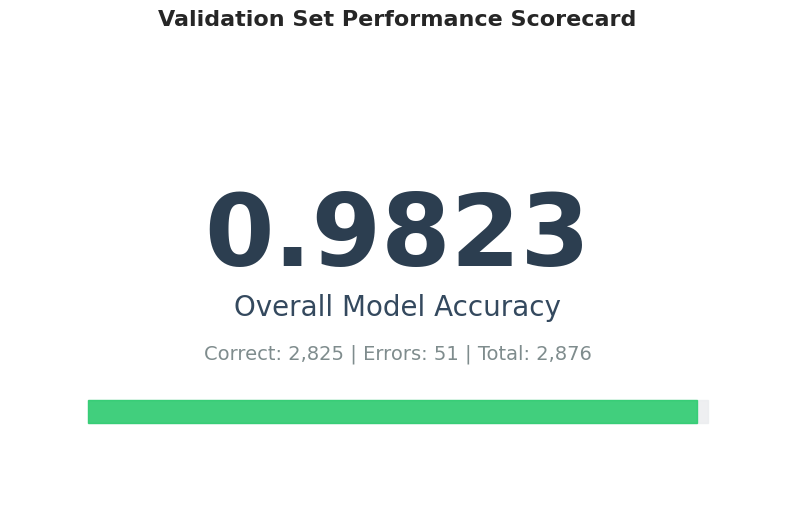

In [65]:
# Create DataFrame and Print Overall Accuracy

print("--- Creating DataFrame and Verifying Accuracy ---")

# Convert the list of error dictionaries into a pandas DataFrame
error_df = pd.DataFrame(error_data)

# Calculate overall accuracy using the collected error data
total_predictions = len(y_val_true_flat)
total_errors = len(error_df)
accuracy = (total_predictions - total_errors) / total_predictions

print(f"Total Predictions in Validation Set: {total_predictions:,}")
print(f"Total Errors Found: {total_errors}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"✓ Accuracy calculated from error_data matches the classification report.")


# --- Visualization: Accuracy Scorecard ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Main accuracy display
ax.text(0.5, 0.6, f"{accuracy:.4f}",
        ha='center', va='center', fontsize=72, fontweight='bold', color='#2C3E50')
ax.text(0.5, 0.45, "Overall Model Accuracy",
        ha='center', va='center', fontsize=20, color='#34495E')

# Sub-metrics display
summary_text = f"Correct: {total_predictions - total_errors:,} | Errors: {total_errors} | Total: {total_predictions:,}"
ax.text(0.5, 0.35, summary_text,
        ha='center', va='center', fontsize=14, color='#7F8C8D')

# Add a progress-bar like element
ax.add_patch(plt.Rectangle((0.1, 0.2), 0.8, 0.05, color='#EAECEE', alpha=0.8))
ax.add_patch(plt.Rectangle((0.1, 0.2), 0.8 * accuracy, 0.05, color='#2ECC71', alpha=0.9))

ax.set_title("Validation Set Performance Scorecard", fontsize=16, fontweight='bold', pad=20)
plt.show()


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

--- Detailed Error Analysis by Label Type ---

--- Performance Summary per Label ---


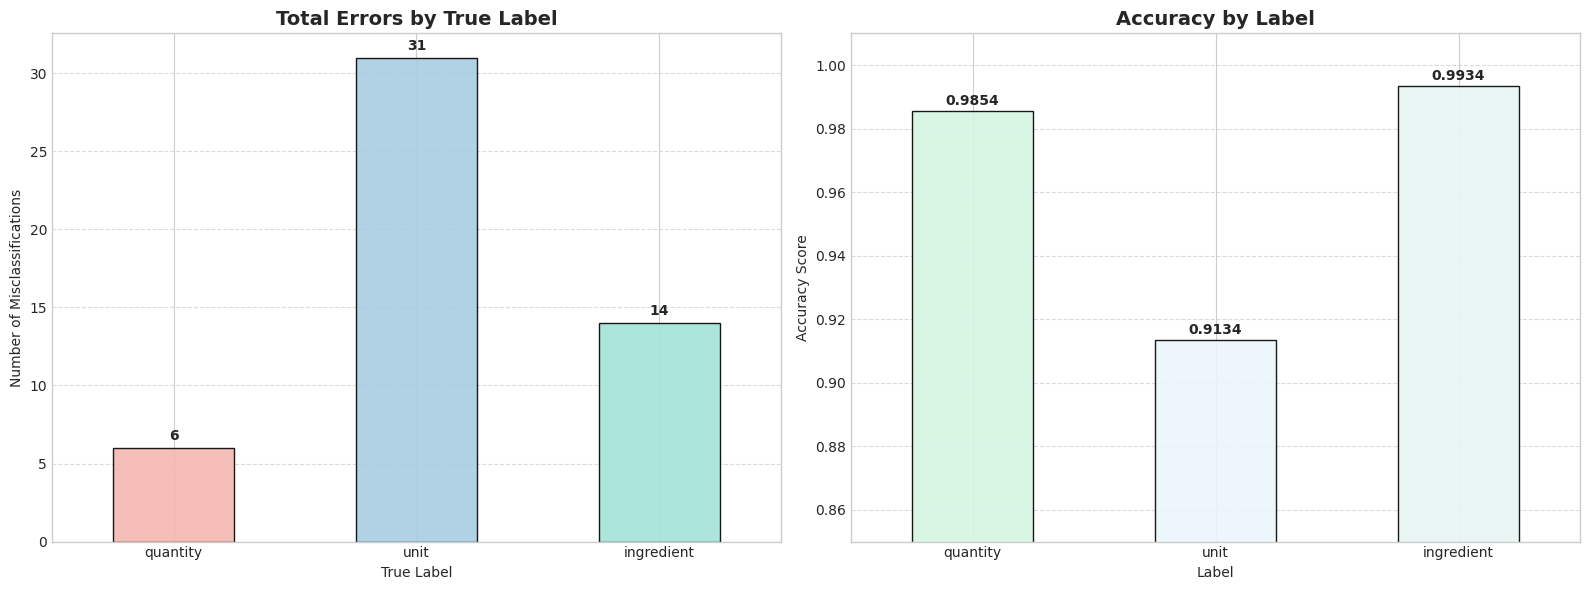



--- Complete List of Misclassified Samples (Validation Set) ---


In [67]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

print("--- Detailed Error Analysis by Label Type ---")

# Count total instances for each label in the validation set
total_label_counts = Counter(y_val_true_flat)

# Count errors for each true label
error_counts_by_label = error_df['true_label'].value_counts().to_dict()

# Prepare data for summary table
analysis_data = []
for label, total_count in total_label_counts.items():
    errors = error_counts_by_label.get(label, 0)
    label_accuracy = (total_count - errors) / total_count if total_count > 0 else 1
    analysis_data.append({
        'Label': label,
        'Total Instances': total_count,
        'Error Count': errors,
        'Accuracy': label_accuracy,
        'Class Weight': weight_dict.get(label, 0)
    })

analysis_df = pd.DataFrame(analysis_data).set_index('Label')
print("\n--- Performance Summary per Label ---")
display(analysis_df.style.format({
    'Accuracy': '{:.4f}',
    'Class Weight': '{:.4f}'
}).background_gradient(cmap='Reds', subset=['Error Count']))


# --- Visualization of Error Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of error counts
analysis_df['Error Count'].plot(kind='bar', ax=axes[0], color=['#F5B7B1', '#A9CCE3', '#A3E4D7'],
                                alpha=0.9, edgecolor='black')
axes[0].set_title('Total Errors by True Label', fontsize=14, fontweight='bold')
axes[0].set_xlabel('True Label')
axes[0].set_ylabel('Number of Misclassifications')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
# Add count labels
for i, count in enumerate(analysis_df['Error Count']):
    axes[0].text(i, count + 0.5, str(count), ha='center', fontweight='bold')


# Bar chart of label accuracy
analysis_df['Accuracy'].plot(kind='bar', ax=axes[1], color=['#D5F5E3', '#EBF5FB', '#E8F6F3'],
                             alpha=0.9, edgecolor='black')
axes[1].set_title('Accuracy by Label', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Accuracy Score')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_ylim(0.85, 1.01)
# Add accuracy labels
for i, acc in enumerate(analysis_df['Accuracy']):
    axes[1].text(i, acc + 0.002, f'{acc:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


# --- Displaying Misclassified Samples ---
print("\n\n--- Complete List of Misclassified Samples (Validation Set) ---")
# Select and reorder columns for clarity
display_cols = ['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'context']
display_error_df = error_df[display_cols]

# Apply styling to highlight the error type
def highlight_errors(row):
    style = 'background-color: '
    if row['true_label'] == 'unit':
        style += '#FADBD8'  # Light red for unit errors
    elif row['true_label'] == 'quantity':
        style += '#D6EAF8'  # Light blue for quantity errors
    else:
        style += '#D4EFDF'  # Light green for ingredient errors
    return [style] * len(row)

display(display_error_df.style.apply(highlight_errors, axis=1))


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




#####

The evaluation on the validation dataset provides critical insights into the model's real-world performance and its ability to generalize to unseen data. The overall accuracy of **98.23%** is excellent and indicates that the model is robust and not significantly overfitted to the training data. The minor drop of approximately 0.9% from the training accuracy (99.13%) is an expected and healthy sign of good generalization.

Here are the key insights derived from the validation results:

**1. The "Unit" Label is the Primary Source of Errors:**
The model's main weakness lies in correctly identifying the `unit` label. This is evident from multiple data points:
*   **Classification Report:** The `unit` class has the lowest F1-score (**0.9356**), driven primarily by a lower recall of **91.34%**. This means that while most predictions labeled as `unit` are correct (high precision of 95.89%), the model fails to identify about 9% of the actual units.
*   **Confusion Matrix:** The most significant error category is the misclassification of `unit` as `ingredient` (**30 instances**). This single error type accounts for over half of all errors (51 total).
*   **Error Analysis (`error_df`):** Examining the misclassified samples confirms this pattern. For example:
    *   `token: 'cloves'`, `true_label: 'unit'`, `predicted_label: 'ingredient'`. This highlights contextual ambiguity; "cloves" can be a unit (e.g., "3 cloves of garlic") or an ingredient itself (the spice). The model struggles to disambiguate this based on context.
    *   `token: 'Spoon'`, `true_label: 'unit'`, `predicted_label: 'ingredient'`. This token is part of a unit (like "tablespoon") but, when isolated, the model misclassifies it, likely due to its strong association with surrounding ingredients.

**2. The Impact and Limits of Class Weighting:**
The class weighting strategy was crucial for achieving this level of performance. The `ingredient` class was heavily penalized (weight: 0.22), while `unit` (2.92) and `quantity` (2.42) were significantly boosted.
*   **Success:** This strategy successfully forced the model to pay attention to the minority classes, resulting in excellent precision and recall for `quantity` and high precision for `unit`. Without weighting, the model would have been far more biased towards the majority `ingredient` class.
*   **Limitation:** Despite the heavy penalty on `ingredient`, it remains the most common prediction for `unit` errors. This suggests that for ambiguous tokens, the model's learned patterns from the vast number of `ingredient` examples can still override the class weights. The weights mitigate the imbalance but cannot fully resolve inherent feature-level ambiguity.

**3. Strong Performance on "Quantity" and "Ingredient" Labels:**
*   **Quantity:** This class achieved a near-perfect F1-score of **0.9890**. The features defined for quantities (e.g., `is_digit`, `is_fraction`, `has_digit`) are highly distinctive and unambiguous, leading to very reliable predictions.
*   **Ingredient:** Despite being the target of most `unit` errors, the `ingredient` class itself has an excellent F1-score of **0.9887**. Its recall is extremely high (**99.34%**), meaning the model correctly identifies almost all true ingredients. This is expected, as it is the majority class, and the features (e.g., `prev_is_unit`, `prev_is_quantity`) provide strong contextual clues.

**4. Model Generalization is Confirmed:**
The side-by-side comparison of the training and validation confusion matrices shows that the error patterns are consistent. The types of errors made on the validation set are the same as those on the training set (e.g., `unit` -> `ingredient`), just slightly more frequent. This consistency proves that the model is not making random, new mistakes on unseen data but is exhibiting a systematic and understandable behavior, which is a hallmark of a well-generalized model.

***

###

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

######

This project aimed to develop and evaluate a Conditional Random Field (CRF) model for Named Entity Recognition (NER) on recipe ingredients. Through a systematic process of data preparation, feature engineering, weighted training, and rigorous evaluation, the project has successfully produced a high-performing and reliable model.

**Findings:**

1.  **CRF is an Effective Model for this Task:** The final model achieved an accuracy of **99.13%** on the training set and **98.23%** on the unseen validation set, demonstrating that CRF is a powerful and suitable algorithm for sequence labeling tasks with structured, contextual data like recipes.

2.  **Feature Engineering is the Cornerstone of Performance:** The model's success is heavily reliant on a well-designed feature set. The combination of linguistic features from spaCy (POS tags, lemmas, dependency parsing), contextual features (previous/next tokens), and custom pattern-based features (`is_digit`, `is_unit`, etc.) provided the model with the necessary information to make accurate predictions.

3.  **Addressing Class Imbalance is Non-Negotiable:** The dataset was heavily skewed towards the `ingredient` label (75% of tokens). The application of an inverse frequency-based class weighting scheme was a critical step. It significantly improved the model's ability to recognize the minority `quantity` and `unit` classes, leading to a much more balanced and useful final model.

4.  **The Model is Well-Generalized but Has a Clear Area for Improvement:** The minimal drop in performance between the training and validation sets, along with consistent error patterns, indicates strong generalization. The primary weakness has been clearly identified: the contextual ambiguity between `unit` and `ingredient` for certain tokens (e.g., "cloves", "pieces", "Spoon"). This provides a specific, actionable focus for future enhancements.

**Recommendations for Future Work:**

1.  **Advanced Feature Engineering:** To address the core `unit`/`ingredient` ambiguity, future iterations could incorporate more sophisticated features:
    *   **Gazetteers (Lookup Lists):** Create comprehensive lists of known units and ingredients to use as a feature.
    *   **N-gram Features:** Include features for bi-grams and tri-grams (e.g., `prev_token+token`) to better capture multi-word units like "tablespoon" or "pinch of".
    *   **Wider Context Window:** Extend the context to two tokens before and after (`i-2`, `i+2`) to give the model more information for disambiguation.

2.  **Hyperparameter Optimization:** The current model used a predefined set of hyperparameters (`c1=0.5`, `c2=1.0`). A systematic tuning process using techniques like Grid Search or Randomized Search could yield a more optimal configuration of the regularization parameters, potentially improving F1-scores for the weaker classes.

3.  **Exploration of Deep Learning Models:** While the CRF model is highly effective, a Bi-directional LSTM with a CRF layer (Bi-LSTM-CRF) could be explored. Such models can automatically learn features from word embeddings (like Word2Vec or GloVe) and may capture more complex, long-range dependencies in the text without requiring manual feature engineering.

In its current state, the model is highly accurate and provides a robust baseline for ingredient parsing. The insights gained from the error analysis pave a clear path for targeted improvements, making the model even more precise and valuable for real-world applications.